In [80]:
%%javascript
/**********************************************************************************************
Known Mathjax Issue with Chrome - a rounding issue adds a border to the right of mathjax markup
https://github.com/mathjax/MathJax/issues/1300
A quick hack to fix this based on stackoverflow discussions: 
http://stackoverflow.com/questions/34277967/chrome-rendering-mathjax-equations-with-a-trailing-vertical-line
**********************************************************************************************/

$('.math>span').css("border-left-color","transparent")

%reload_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

# DAMLAS - Machine Learning At Scale
## Assignment - HW3
Data Analytics and Machine Learning at Scale
Target, Minneapolis

---
__Name:__  Mark Lidstone  
__Class:__ DAMLAS Summer 2016    
__Email:__  mark.lidstone@target.com  
__Week:__   03

# Table of Contents <a name="TOC"></a> 

1.  [HW Introduction](#1)   
2.  [HW References](#2)
3.  [HW Problems](#3)   
    3.0.  [Short Answer Questions](#HW3.0)    
    3.1.  [Word Count plus sorting](#HW3.1)   
    3.2.  [MLlib-centric Kmeans](#HW3.2)    
    3.3.  [Homegrown KMeans in Spark](#HW3.3)    
    3.4.  [Making Homegrown KMeans more efficient](#HW3.4)  
    3.5.  [OPTIONAL Weighted KMeans](#HW3.5)  
    3.6.  [OPTIONAL Linear Regression](#HW3.6)  
    3.7.  [OPTIONAL Error surfaces](#HW3.7)



<a name="1">
# 1 Instructions
[Back to Table of Contents](#TOC)
* Homework submissions are due by Tueday, 08/02/2016 at 11AM (CT).


* Prepare a single Jupyter note, please include questions, and question numbers in the questions and in the responses.
Submit your homework notebook via the following form:

   + [Submission Link - Google Form](http://goo.gl/forms/er3OFr5eCMWDngB72)


### Documents:
* IPython Notebook, published and viewable online.
* PDF export of IPython Notebook.
    
<a name="2">
# 2 Useful References
[Back to Table of Contents](#TOC)

* Karau, Holden, Konwinski, Andy, Wendell, Patrick, & Zaharia, Matei. (2015). Learning Spark: Lightning-fast big data analysis. Sebastopol, CA: O’Reilly Publishers.
* Hastie, Trevor, Tibshirani, Robert, & Friedman, Jerome. (2009). The elements of statistical learning: Data mining, inference, and prediction (2nd ed.). Stanford, CA: Springer Science+Business Media. __(Download for free [here](http://statweb.stanford.edu/~tibs/ElemStatLearn/printings/ESLII_print10.pdf))__
* Ryza, Sandy, Laserson, Uri, Owen, Sean, & Wills, Josh. (2015). Advanced analytics with Spark: Patterns for learning from data at scale. Sebastopol, CA: O’Reilly Publishers.
---
* [Slides for Supervised-ML-Classification-via-GradientDescent](https://www.dropbox.com/s/uzoch1dwft8kaqw/Lecture-15-Supervised-ML-Classification-via-GradientDescent.pdf?dl=0)
* [Slides from High Entropy Friday]( https://www.dropbox.com/s/0dlvsff3660vvbk/Lecture-High-Entropy-Friday.pdf?dl=0)

---

<a name="HW3">
# 3 HW Problems
[Back to Table of Contents](#TOC)

<a name="3.0"></a><h2 style="color:darkblue"> HW3.0: Short answer questions </h2>
[Back to Table of Contents](#TOC)


__What is Apache Spark and how is it different to Apache Hadoop? __
    Spark uses distributed memory as opposed to hadoop which distributes across disk. Spark is a higher level system
__Fill in the blanks:
Spark API consists of interfaces to develop applications based on it in Java, ___ BLANKS __ languages (list languages). __
Scala, Python
<hr>

__Using Spark, resource management can be done either in a single server instance or using a framework such as Mesos or ????? in a distributed manner. __
SparkContext along with the parallelize command, will allow for parallelized computing. 
<hr>

__What is an RDD and show a fun example of creating one and bringing the first element back to the driver program. __
an RDD(resilient distributed dataset) is the basic key value structure in Spark. 
<hr>


In [101]:
fundata = ["jimi", 2, 3, 4, 5]
funRDD = sc.parallelize(fundata)
funRDD.take(1)

['jimi']

<a name="HW3.1"> <h2 style="color:darkgreen">HW3.1 WordCount plus sorting </h2>
[Back to Table of Contents](#TOC)

The following notebooks will be useful to jumpstart this collection of Homework exercises:


* [Example Notebook with Debugging tactics in Spark](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/jqjllp8kmf1eolk/WordCountDebugging-Example.ipynb)
* [Word Count Quiz](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/vgmpivsi4rvqz0s/WordCountQuiz.ipynb)
* [Work Count Solution](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/dxv3dmp1vluuo8i/WordCountQuiz-Solution.ipynb)

---
In Spark write the code to count how often each word appears in a text document (or set of documents). Please use this homework document (with no solutions in it) as a the example document to run an experiment.  Report the following: 
* provide a sorted list of tokens in decreasing order of frequency of occurence limited to [top 20 most frequent only] and [bottom 10 least frequent]. 


__OPTIONAL__ 
Feel free to do a secondary sort where words with the same frequncy are sorted alphanumerically increasing. Plseas refer to the [following notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/uu5afr3ufpm9fy8/SecondarySort.ipynb)
 for examples of secondary sorts in Spark. Please provide the following [top 20 most frequent terms only] and [bottom 10 least frequent terms]

__NOTE__ [Please incorporate all referenced notebooks directly into this master notebook as cells for HW submission. I.e., HW submissions should comprise of just one notebook]__

In [1]:
import os
import sys #current as of 9/26/2015

# spark_home = os.environ['SPARK_HOME'] = '/Users/jshanahan/Dropbox/Lectures-UC-Berkeley-ML-Class-2015/spark-1.6.1-bin-hadoop2.6/'
spark_home = os.environ['SPARK_HOME'] = '/Users/z013l75/spark-1.6.2-bin-hadoop2.6/'


if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.9-src.zip'))

# First, we initialize the Spark environment

#import findspark
#findspark.init()

import pyspark
from pyspark.sql import SQLContext

# We can give a name to our app (to find it in Spark WebUI) and configure execution mode
# In this case, it is local multicore execution with "local[*]"
app_name = "example-logs"
master = "local[*]"
conf = pyspark.SparkConf().setAppName(app_name).setMaster(master)
sc = pyspark.SparkContext(conf=conf)
sqlContext = SQLContext(sc)


print(sc)
print(sqlContext)


# Import some libraries to work with dates
import dateutil.parser
import dateutil.relativedelta as dateutil_rd

# top 20 words

In [2]:

text_file = sc.textFile('HW3.txt')
counts = text_file.flatMap(lambda line: line.split(" ")) \
    .map(lambda word: (word, 1)) \
    .reduceByKey(lambda a, b: a + b, 1) \
    .sortBy(lambda a:a[1],0)
wordCounts = counts.collect()
for v in wordCounts[:20]:
    print v

(u'the', 71)
(u'', 68)
(u'of', 49)
(u'and', 40)
(u'to', 33)
(u'in', 32)
(u'##', 27)
(u'a', 23)
(u'this', 17)
(u'Contents', 17)
(u'Table', 17)
(u'for', 17)
(u'Back', 16)
(u'with', 14)
(u'as', 13)
(u'&', 12)
(u'data', 12)
(u'KMeans', 12)
(u'code', 11)
(u'here', 11)


## bottom 10

In [3]:

text_file = sc.textFile('HW3.txt')
counts = text_file.flatMap(lambda line: line.split(" ")) \
    .map(lambda word: (word, 1)) \
    .reduceByKey(lambda a, b: a + b, 1) \
    .sortBy(lambda a:a[1],1)
wordCounts = counts.collect()
for v in wordCounts[:10]:
    print v

(u'limited', 1)
(u'forget', 1)
(u'Here@Target.com', 1)
(u'during', 1)
(u'Holden,', 1)
(u'consists', 1)
(u'inverse', 1)
(u'HW3.1', 1)
(u'graph', 1)
(u'HW3.7', 1)


<a name="HW3.1.1"><h2 style="color:darkgreen">HW3.1.1 </h2>
[Back to Table of Contents](#TOC)

Modify the above word count code to count words that begin with lower case letters (a-z) and report your findings. Again sort the output words in decreasing order of frequency.


In [4]:

counts = text_file.flatMap(lambda line: line.split(" ")) 
filter_text = counts.filter(lambda x: x.islower())\
    .map(lambda word: (word, 1)) \
    .reduceByKey(lambda a, b: a + b, 1) \
    .sortBy(lambda a:a[1],0)
wordCounts = filter_text.collect()
for v in wordCounts:
    print v

(u'the', 71)
(u'of', 49)
(u'and', 40)
(u'to', 33)
(u'in', 32)
(u'a', 23)
(u'this', 17)
(u'for', 17)
(u'with', 14)
(u'as', 13)
(u'data', 12)
(u'code', 11)
(u'here', 11)
(u'model', 11)
(u'plot', 10)
(u'is', 10)
(u'goes', 9)
(u'your', 8)
(u'from', 7)
(u'notebook', 7)
(u'each', 7)
(u'linear', 7)
(u'on', 7)
(u'following', 6)
(u'domain', 6)
(u'regression', 6)
(u'clusters', 5)
(u'training', 5)
(u'one', 5)
(u'it', 5)
(u'provided', 5)
(u'more', 4)
(u'notebooks', 4)
(u'side', 4)
(u'space', 4)
(u'words', 4)
(u'submissions', 4)
(u'using', 4)
(u'at', 4)
(u'all', 3)
(u'results', 3)
(u'example', 3)
(u'after', 3)
(u'frequent', 3)
(u'directly', 3)
(u'master', 3)
(u'that', 3)
(u'iteration', 3)
(u'most', 3)
(u'incorporate', 3)
(u'show', 3)
(u'should', 3)
(u'above', 3)
(u'import', 3)
(u'report', 3)
(u'homegrown', 3)
(u'x', 3)
(u'document', 3)
(u'comprise', 3)
(u'just', 3)
(u'submission.', 3)
(u'plots', 3)
(u'by', 3)
(u'referenced', 3)
(u'into', 3)
(u'function', 3)
(u'count', 3)
(u'cells', 3)
(u'every', 2)

In [86]:
## Drivers & Runners

In [87]:
## Run Scripts, S3 Sync

<a name="HW3.2"> <h2 style="color:darkblue"> HW3.2: MLlib-centric KMeans</h2>
[Back to Table of Contents](#TOC)

Using the following  MLlib-centric KMeans code snippet: 

<pre>
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt


# Load and parse the data
# NOTE  kmeans_data.txt is available here 
#          https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 
data = sc.textFile("kmeans_data.txt")  
parsedData = data.map(lambda line: array([float(x) for x in line.split(' ')]))

# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 2, maxIterations=10,
        runs=10, initializationMode="random")
for centro
# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

# Save and load model
clusters.save(sc, "myModelPath")
sameModel = KMeansModel.load(sc, "myModelPath")

</pre>

__NOTE__ <p> The  __kmeans_data.txt__ is available here https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 

__TASKS__
* Run this code snippet and list the clusters that your find.
* compute the Within Set Sum of Squared Errors for the found clusters. Comment on your findings.

In [5]:

from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt


# Load and parse the data
# NOTE  kmeans_data.txt is available here 
#          https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 
data = sc.textFile("kmeans_data.txt")  
parsedData = data.map(lambda line: array([float(x) for x in line.split(' ')]))

# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 2, maxIterations=10, runs=10, initializationMode="random")
for centroid in clusters.centers:
    print centroid
# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))


# Save and load model
clusters.save(sc, "myModelPath")
sameModel = KMeansModel.load(sc, "myModelPath")


/Users/z013l75/spark-1.6.2-bin-hadoop2.6/python/pyspark/mllib/clustering.py:176: UserWarning: Support for runs is deprecated in 1.6.0. This param will have no effect in 1.7.0.
  "Support for runs is deprecated in 1.6.0. This param will have no effect in 1.7.0.")


[ 0.1  0.1  0.1]
[ 9.1  9.1  9.1]
Within Set Sum of Squared Error = 0.692820323028


Py4JJavaError: An error occurred while calling o110.save.
: org.apache.hadoop.mapred.FileAlreadyExistsException: Output directory file:/Users/z013l75/myModelPath/metadata already exists
	at org.apache.hadoop.mapred.FileOutputFormat.checkOutputSpecs(FileOutputFormat.java:132)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopDataset$1.apply$mcV$sp(PairRDDFunctions.scala:1177)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopDataset$1.apply(PairRDDFunctions.scala:1154)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopDataset$1.apply(PairRDDFunctions.scala:1154)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:316)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1154)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$4.apply$mcV$sp(PairRDDFunctions.scala:1060)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$4.apply(PairRDDFunctions.scala:1026)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$4.apply(PairRDDFunctions.scala:1026)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:316)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1026)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$1.apply$mcV$sp(PairRDDFunctions.scala:952)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$1.apply(PairRDDFunctions.scala:952)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$1.apply(PairRDDFunctions.scala:952)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:316)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:951)
	at org.apache.spark.rdd.RDD$$anonfun$saveAsTextFile$1.apply$mcV$sp(RDD.scala:1457)
	at org.apache.spark.rdd.RDD$$anonfun$saveAsTextFile$1.apply(RDD.scala:1436)
	at org.apache.spark.rdd.RDD$$anonfun$saveAsTextFile$1.apply(RDD.scala:1436)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:316)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1436)
	at org.apache.spark.mllib.clustering.KMeansModel$SaveLoadV1_0$.save(KMeansModel.scala:131)
	at org.apache.spark.mllib.clustering.KMeansModel.save(KMeansModel.scala:96)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:381)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:209)
	at java.lang.Thread.run(Thread.java:745)


Since the sample is so small, the clusters match up with the data almost exactly. I believe the sample size is too small to run this sort of clustering algorithm.

In [90]:
## Run Scripts, S3 Sync

<a name="HW3.3"><h2 style="color:darkgreen"> HW3.3: Homegrown KMeans in Spark </h2>
[Back to Table of Contents](#TOC)

Download the following KMeans [notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb).

Generate 3 clusters with 100 (one hundred) data points per cluster (using the code provided). Plot the data.
Then run MLlib's Kmean implementation on this data  and report your results as follows:

* plot the resulting clusters after 1 iteration, 10 iterations, after 20 iterations, after 100 iterations.
* in each plot please report the Within Set Sum of Squared Errors for the found clusters (as part of the title WSSSE). Comment on the progress of this measure as  the KMEans algorithms runs for more iterations. Then plot the WSSSE as a function of the iteration (1, 10, 20, 30, 40, 50, 100).



In [6]:
%matplotlib inline
import numpy as np
import pylab 
import json
size1 = size2 = size3 = 100
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)
# Randomlize data
data = data[np.random.permutation(size1+size2+size3),]
np.savetxt('NEW_kmeans_data.txt',data,delimiter = ',')

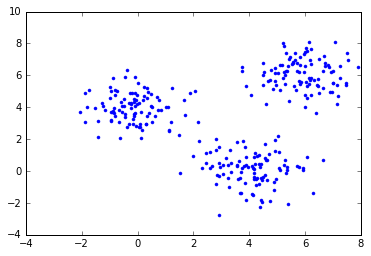

In [7]:
pylab.plot(data[:, 0], data[:, 1], '.', color = 'blue')
pylab.show()

[ 6.25959662  7.18048222]
[ 5.75005459  5.19467071]
[ 1.84530151  2.07054382]
Within Set Sum of Squared Error = 699.027199624
[ 5.88928783  6.0885672 ]
[-0.13688955  3.97680788]
[ 4.06731716  0.10368867]
Within Set Sum of Squared Error = 355.744702637
[-0.13688955  3.97680788]
[ 5.88928783  6.0885672 ]
[ 4.06731716  0.10368867]
Within Set Sum of Squared Error = 355.744702637
[ 4.06731716  0.10368867]
[ 5.88928783  6.0885672 ]
[-0.13688955  3.97680788]
Within Set Sum of Squared Error = 355.744702637
[ 5.88928783  6.0885672 ]
[-0.13688955  3.97680788]
[ 4.06731716  0.10368867]
Within Set Sum of Squared Error = 355.744702637
[ 5.88928783  6.0885672 ]
[ 4.06731716  0.10368867]
[-0.13688955  3.97680788]
Within Set Sum of Squared Error = 355.744702637
[ 4.06731716  0.10368867]
[ 5.88928783  6.0885672 ]
[-0.13688955  3.97680788]
Within Set Sum of Squared Error = 355.744702637


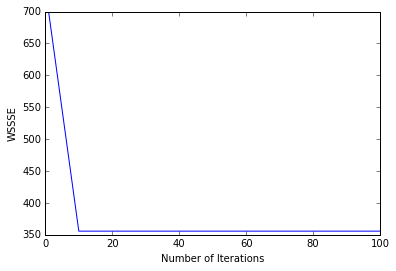

In [8]:

from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt


# Load and parse the data
# NOTE  kmeans_data.txt is available here 
#          https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 
data = sc.textFile("New_kmeans_data.txt")  
parsedData = data.map(lambda line: array([float(x) for x in line.split(',')]))

errorlist = []
x= [1,10,20,30,40,50,100]
for i in x:
    clusters = KMeans.train(parsedData, 3, maxIterations=i, runs=i, initializationMode="random")
    for centroid in clusters.centers:
        print centroid
# Evaluate clustering by computing Within Set Sum of Squared Errors
    def error(point):
        center = clusters.centers[clusters.predict(point)]
        return sqrt(sum([x**2 for x in (point - center)]))

    WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    print("Within Set Sum of Squared Error = " + str(WSSSE))
    errorlist += (x, WSSSE)
import matplotlib.pyplot as plt
pointstoplot = errorlist[1], errorlist[3], errorlist[5], errorlist[7], errorlist[9], errorlist[11], errorlist[13]
xaxis= 1, 10, 20, 30, 40, 50, 100
#pointstoplot= errorlist[1:9]
plt.plot(xaxis, pointstoplot)
plt.ylabel('WSSSE')
plt.xlabel('Number of Iterations')
plt.show()


# Save and load model
#clusters.save(sc, "myModelPaths")
#sameModel = KMeansModel.load(sc, "myModelPaths")



It was interesting that after 1 iteration, the sum of squared errot stayed identical, regardless of the number of iterations. 

<a name="HW3.4"><h2 style="color:darkblue"> HW3.4: KMeans Experiments  </h2>
[Back to Table of Contents](#TOC)

Using this provided [homegrown Kmeans code](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb)   repeat the experiments in HW3.3. Explain any differences between the results in HW3.3 and HW3.4. 

In [9]:
import numpy as np

#Calculate which class each data point belongs to
def nearest_centroid(line):
    x = np.array([float(f) for f in line.split(',')])
    closest_centroid_idx = np.sum((x - centroids)**2, axis=1).argmin()
    return (closest_centroid_idx,(x,1))

#plot centroids and data points for each iteration
def plot_iteration(means):
    pylab.plot(samples1[:, 0], samples1[:, 1], '.', color = 'blue')
    pylab.plot(samples2[:, 0], samples2[:, 1], '.', color = 'blue')
    pylab.plot(samples3[:, 0], samples3[:, 1],'.', color = 'blue')
    pylab.plot(means[0][0], means[0][1],'*',markersize =10,color = 'red')
    pylab.plot(means[1][0], means[1][1],'*',markersize =10,color = 'red')
    pylab.plot(means[2][0], means[2][1],'*',markersize =10,color = 'red')
    pylab.show()

def error(point):
    x = np.array([float(f) for f in point.split(',')])
    closest_centroid_idx2 = np.sum((x - centroids)**2, axis=1).argmin()
    error_amount= np.sqrt(np.sum((x - centroids[closest_centroid_idx2])**2))
    return (error_amount)

Iteration0
[[ 1.42284207  0.95611688]
 [ 4.29355999  2.74604454]
 [ 2.27887006  5.68378739]]
WSSSE= 1084.03235037


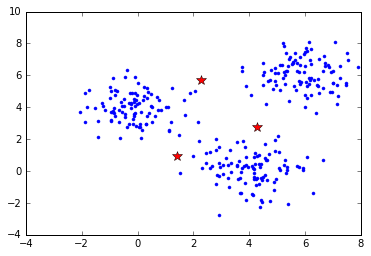

[0, 1084.0323503724783]
Iteration1
[[ 1.73282193  1.25002618]
 [ 5.45642164  2.71923605]
 [ 2.58977632  5.57084745]]
WSSSE= 860.764936391


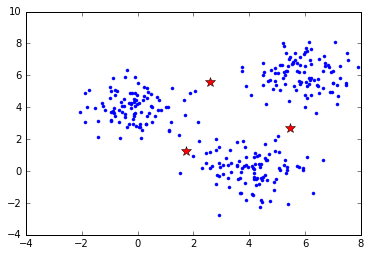

[0, 1084.0323503724783, 1, 860.76493639085311]
Iteration2
[[ 1.89120421  1.29734571]
 [ 5.8020802   3.18774763]
 [ 2.69858765  5.62580721]]
WSSSE= 828.540730722


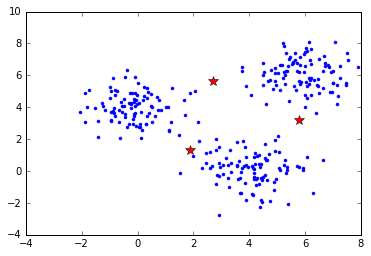

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893]
Iteration3
[[ 2.19129431  1.20119863]
 [ 6.09227926  4.12761028]
 [ 2.48419757  5.60676534]]
WSSSE= 813.625268578


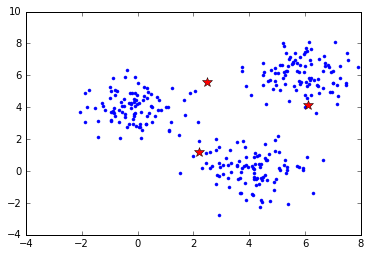

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978]
Iteration4
[[ 3.02292681  0.74855376]
 [ 6.05576492  5.83244979]
 [ 0.52638433  4.75791242]]
WSSSE= 744.963434284


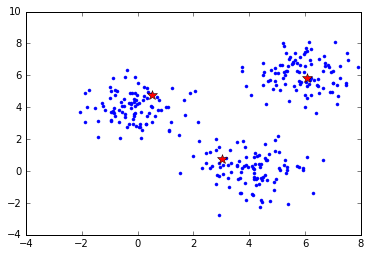

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155]
Iteration5
[[ 4.04185119  0.12488141]
 [ 5.88928783  6.0885672 ]
 [-0.15328422  3.99427176]]
WSSSE= 436.083060591


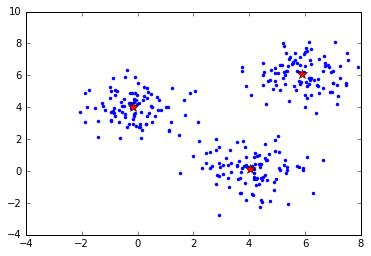

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715]
Iteration6
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.627857699


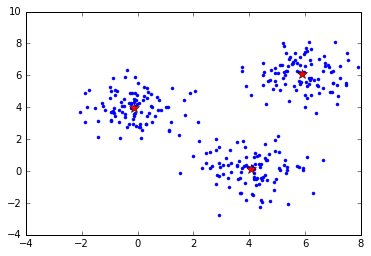

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262]
Iteration7
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


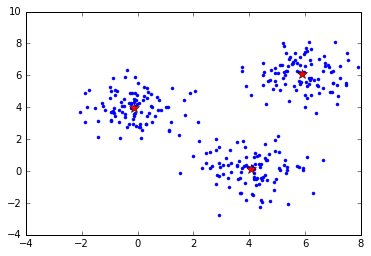

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043]
Iteration8
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


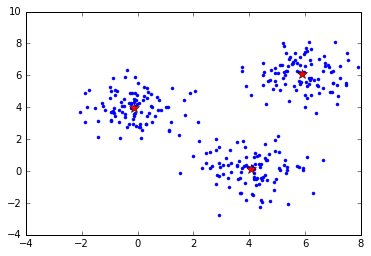

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043]
Iteration9
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


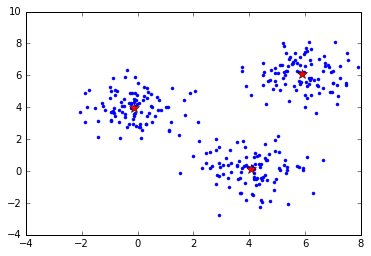

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043]
Iteration10
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


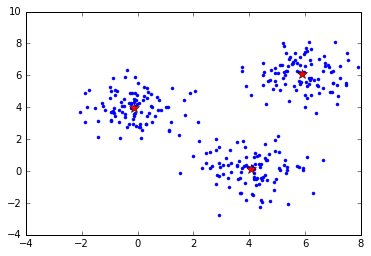

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043]
Iteration11
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


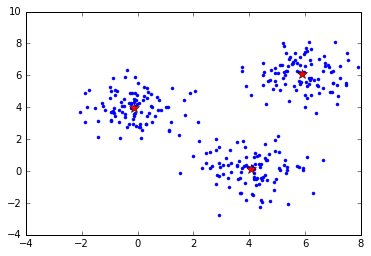

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043]
Iteration12
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


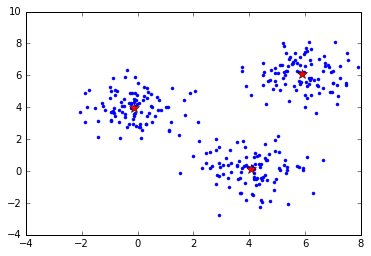

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043]
Iteration13
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


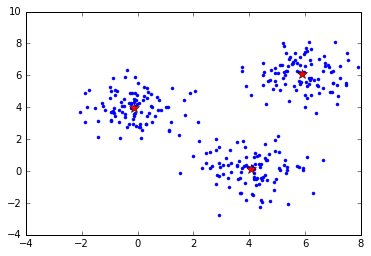

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043]
Iteration14
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


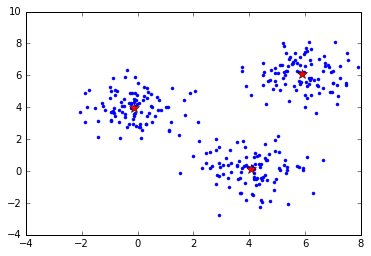

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043]
Iteration15
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


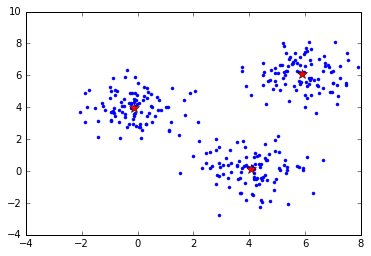

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043]
Iteration16
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


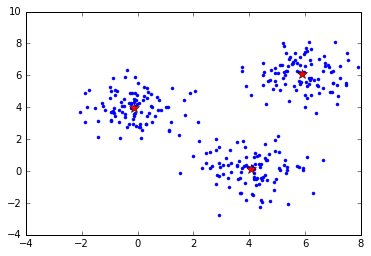

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043]
Iteration17
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


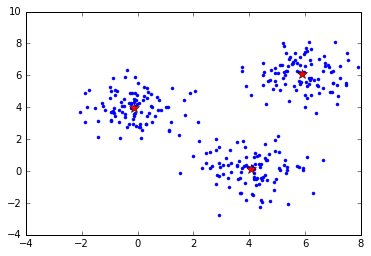

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043]
Iteration18
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


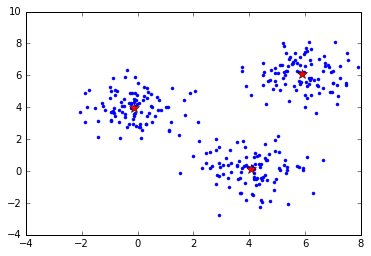

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043]
Iteration19
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


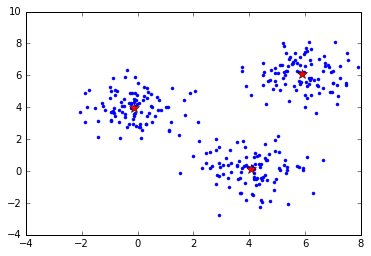

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043]
Iteration20
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


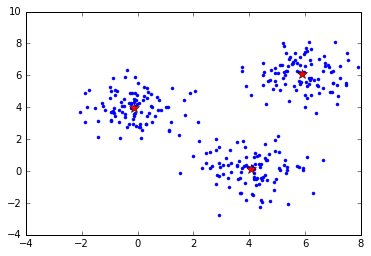

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043]
Iteration21
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


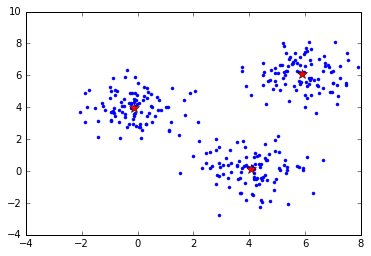

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043]
Iteration22
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


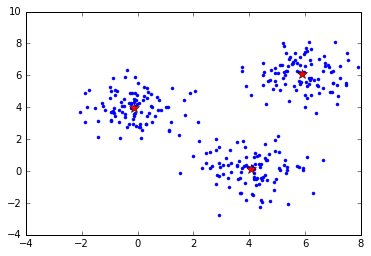

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043]
Iteration23
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


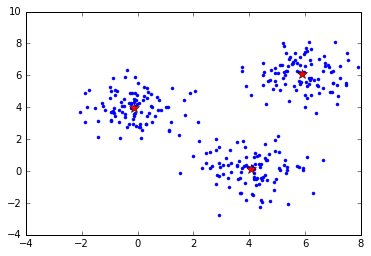

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043]
Iteration24
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


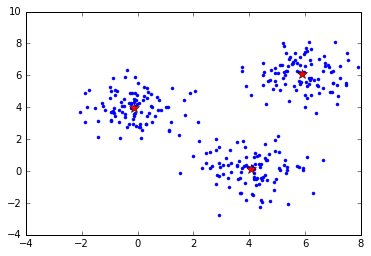

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043]
Iteration25
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


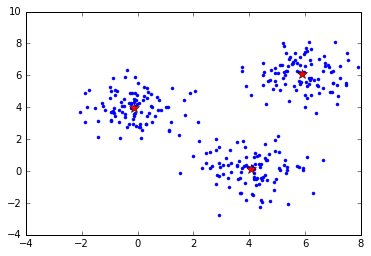

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043]
Iteration26
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


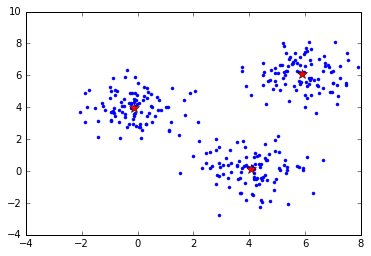

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043]
Iteration27
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


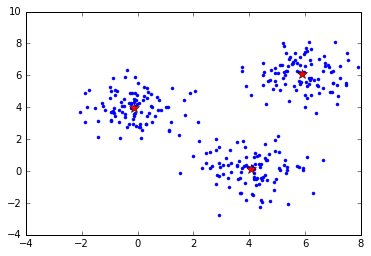

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043]
Iteration28
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


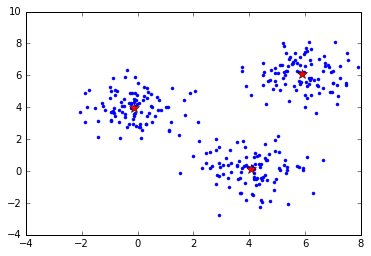

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043]
Iteration29
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


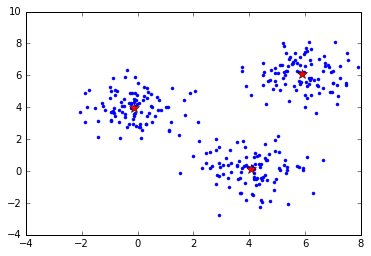

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043]
Iteration30
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


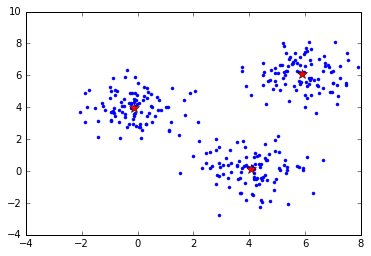

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043]
Iteration31
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


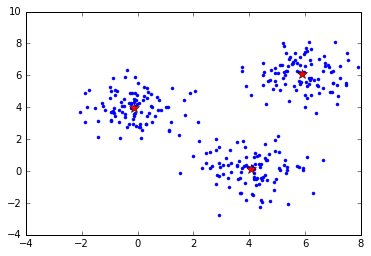

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043]
Iteration32
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


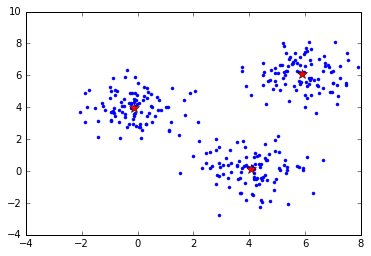

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043]
Iteration33
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


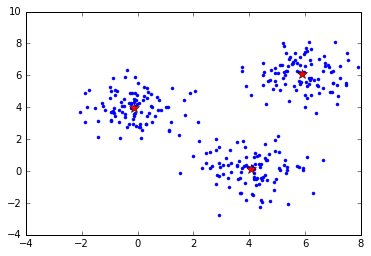

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043]
Iteration34
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


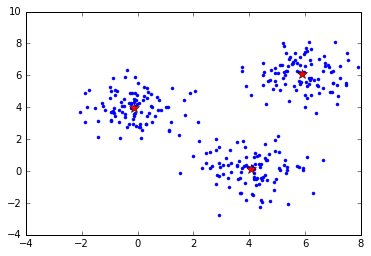

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043]
Iteration35
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


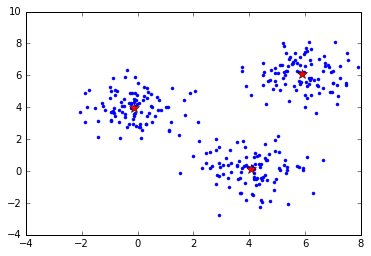

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043]
Iteration36
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


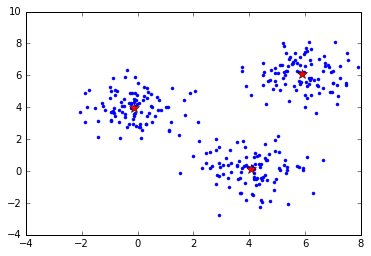

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043]
Iteration37
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


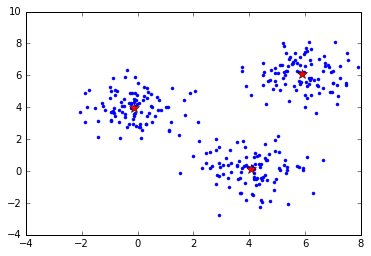

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043]
Iteration38
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSS

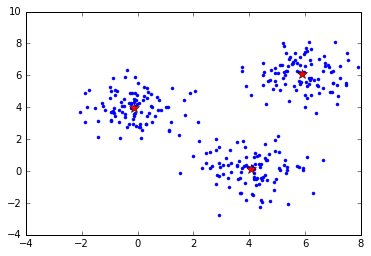

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043]
Iteration39
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.136

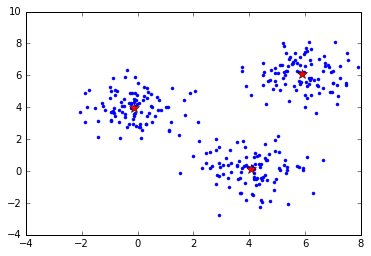

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043]
Iteration40
[[ 4.06731716  0.10368867]
 [ 5.889287

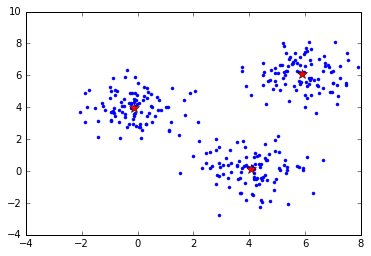

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043]
Iteration41
[[ 4.06731716 

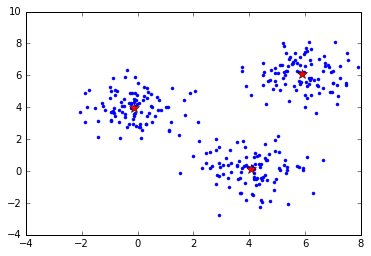

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043]
It

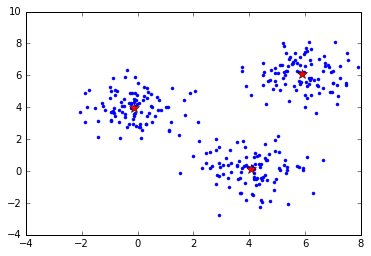

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

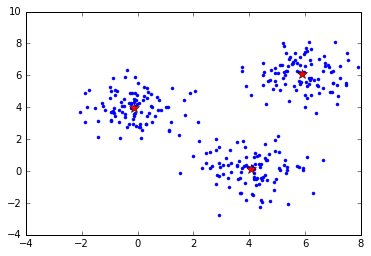

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

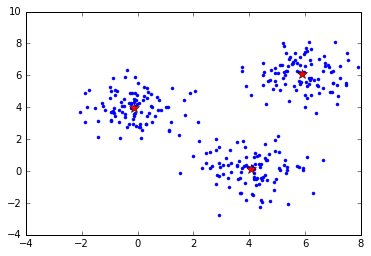

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

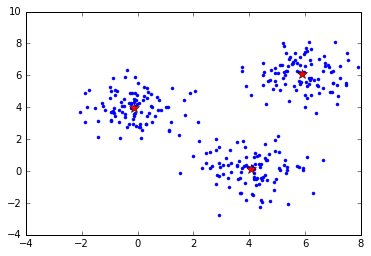

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

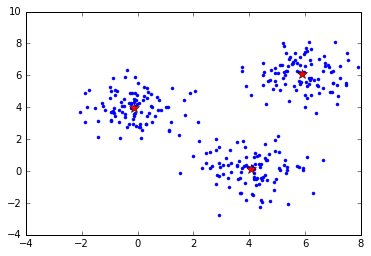

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

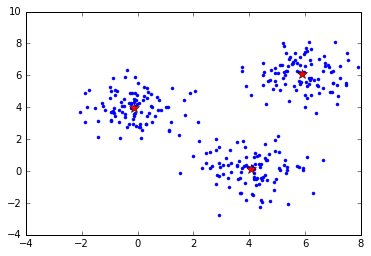

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

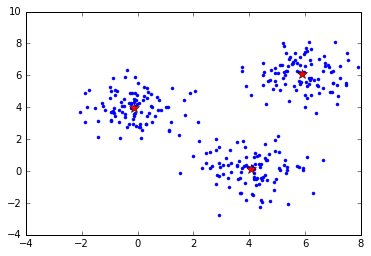

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

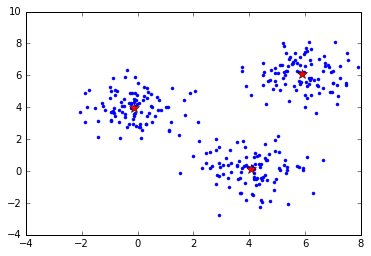

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

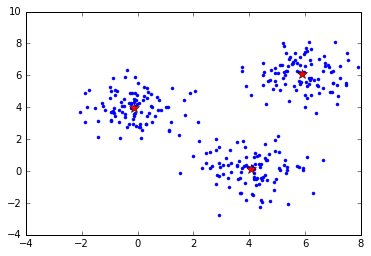

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

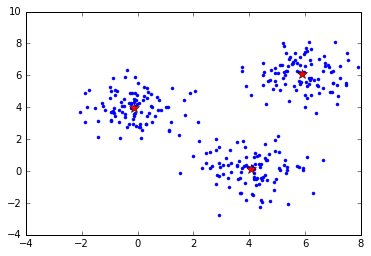

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

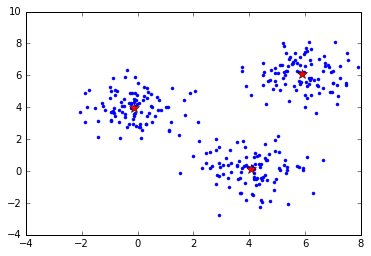

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

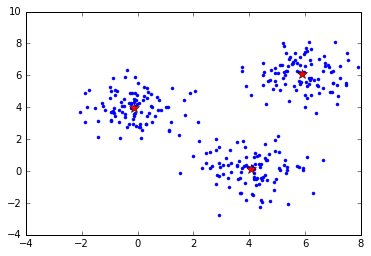

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

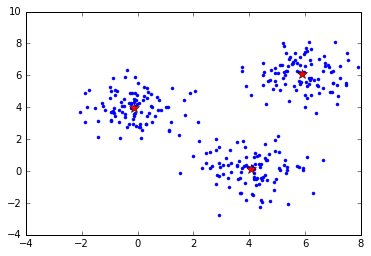

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

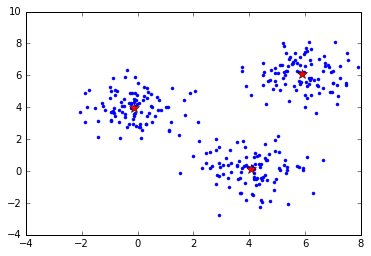

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

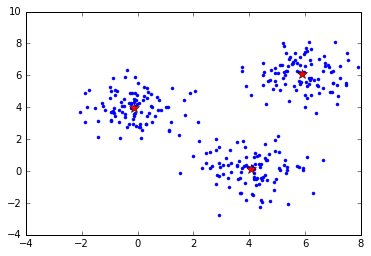

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

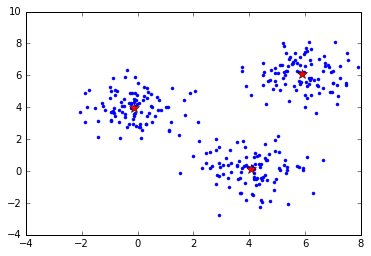

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

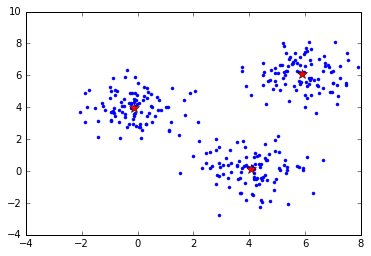

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

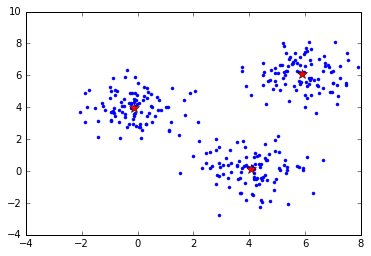

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

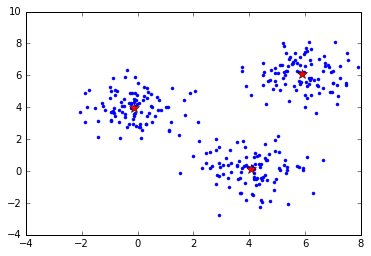

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

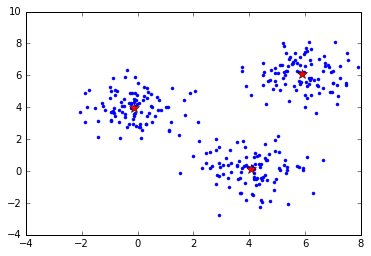

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

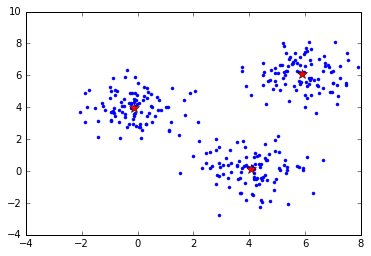

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

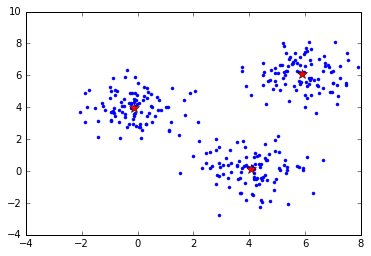

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

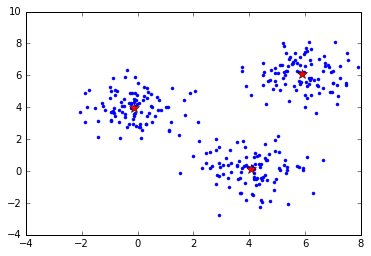

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

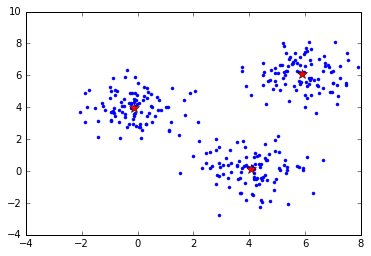

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

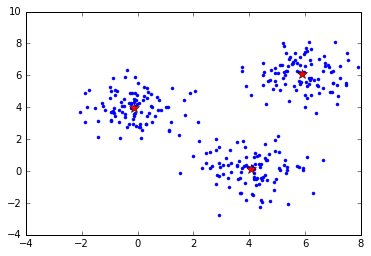

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

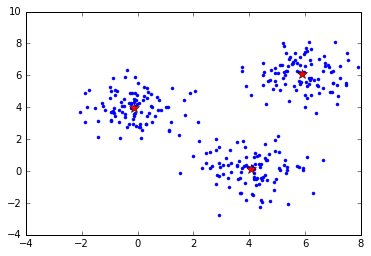

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

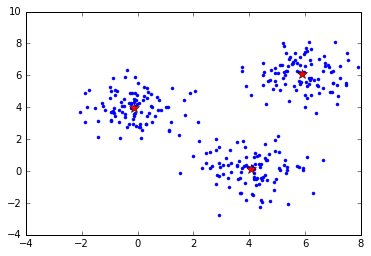

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

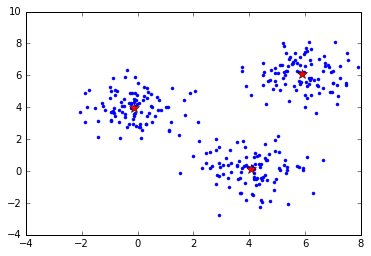

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

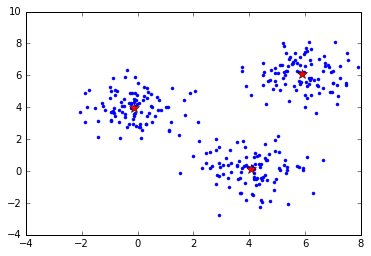

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

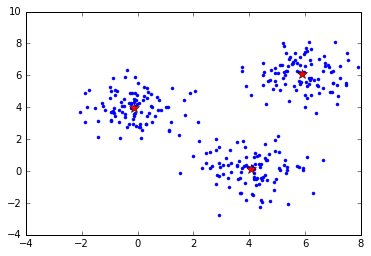

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

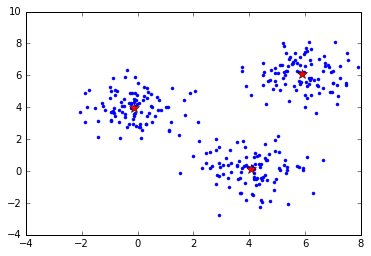

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

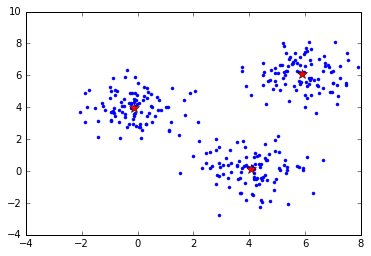

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

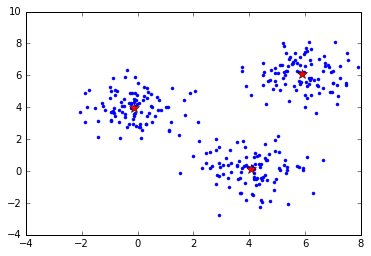

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

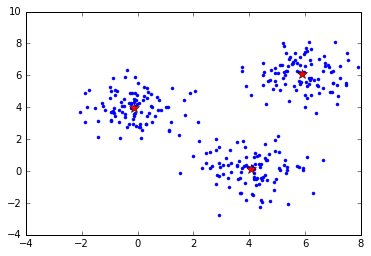

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

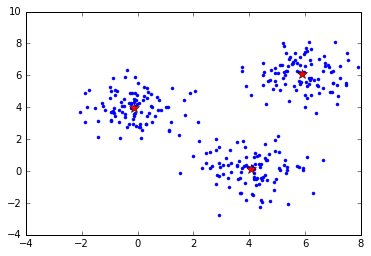

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

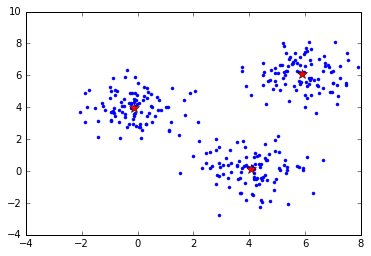

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

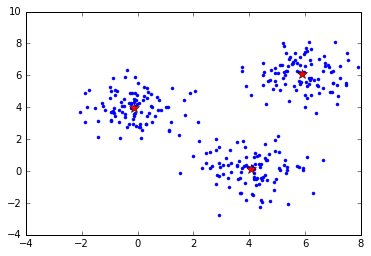

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

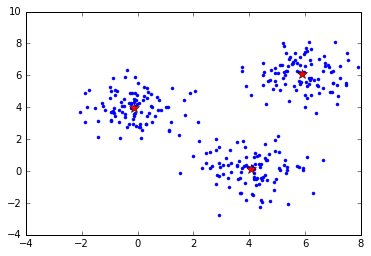

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

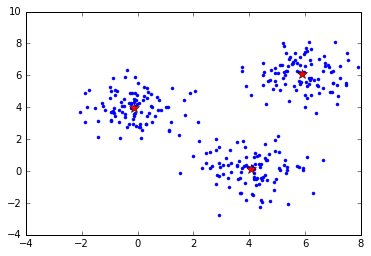

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

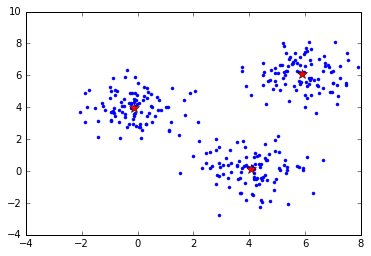

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

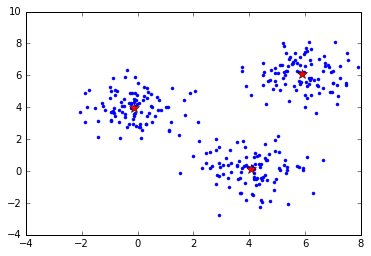

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

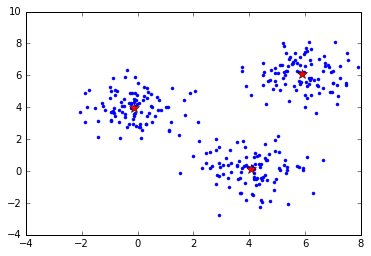

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

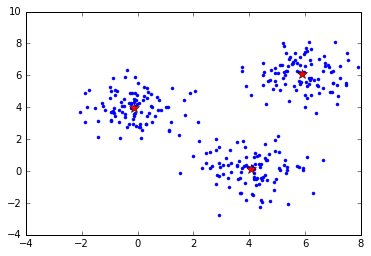

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

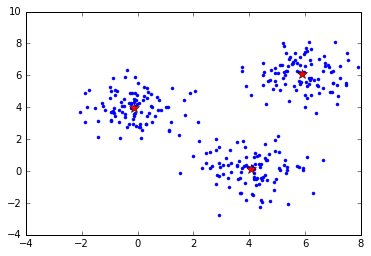

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

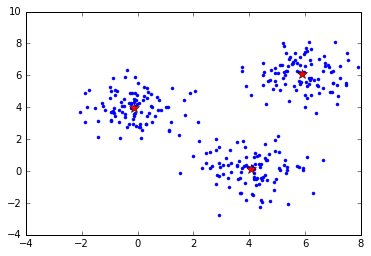

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

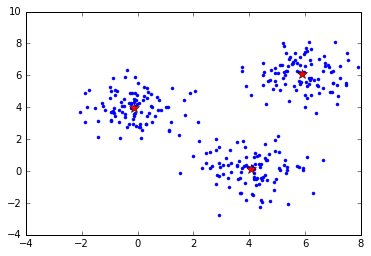

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

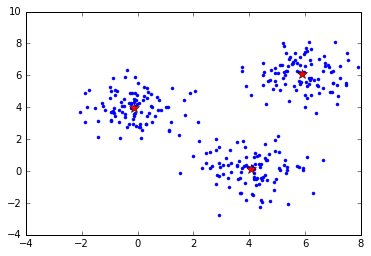

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

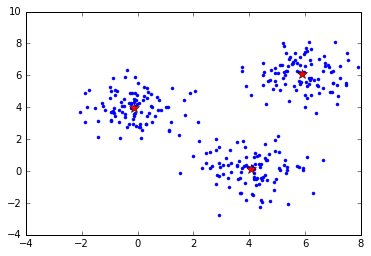

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

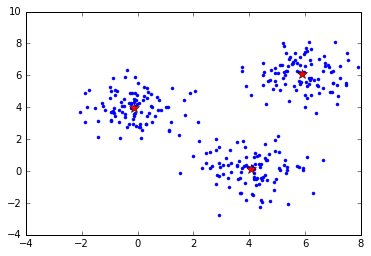

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

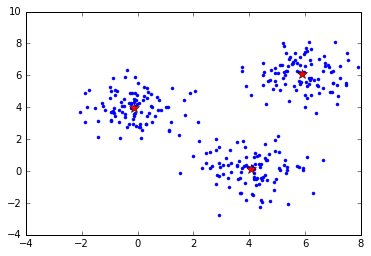

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

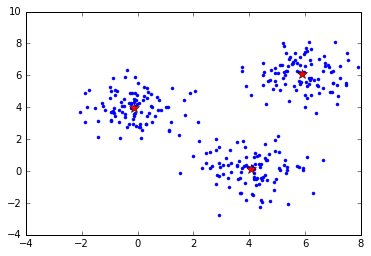

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

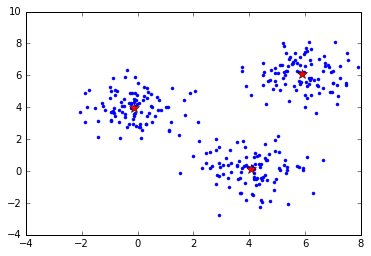

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

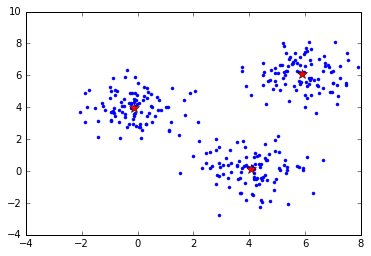

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

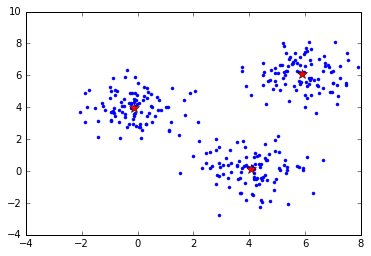

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

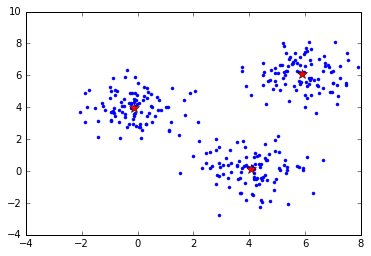

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

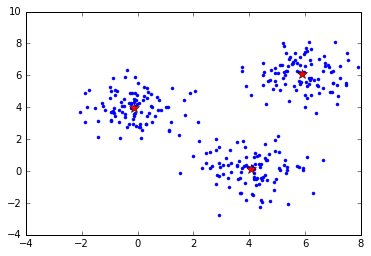

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

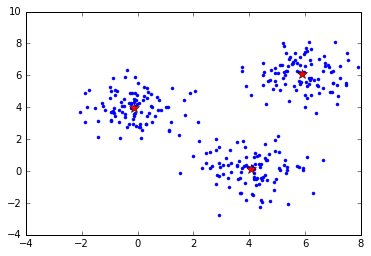

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

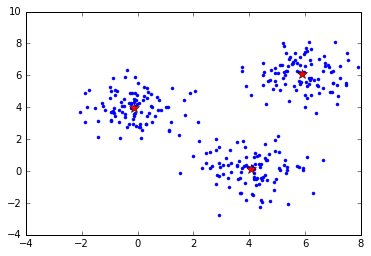

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

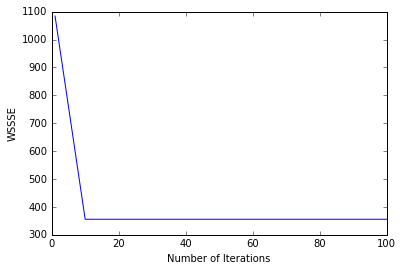

Final Results:
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]


In [10]:
from numpy import array
from math import sqrt
K = 3
# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[1.0,1.0],[2.0,2.0],[0.0,7.0]])

D = sc.textFile("NEW_kmeans_data.txt").cache()
parsedData2 = D.map(lambda line: array([float(x) for x in line.split(' ')]))
iter_num = 0
errorlist = []
for i in range(100):  
    res = D.map(nearest_centroid).reduceByKey(lambda x,y:(x[0]+y[0],x[1]+y[1])).collect() # fill in the missing code
    errorval = D.map(error).reduce(lambda x, y: (x+y))
    res = sorted(res,key = lambda x : x[0])  #sort based on clusted ID
    centroids_new = np.array([x[1][0]/x[1][1] for x in res])  #divide by cluster size
    #if np.sum(np.absolute(centroids_new-centroids))<.001:
        #break
    print "Iteration" + str(iter_num)
    errorlist += iter_num, errorval
    iter_num = iter_num + 1 
    centroids = centroids_new
    print centroids
    print "WSSSE=", errorval
    plot_iteration(centroids)
    #for i in error_val:
    print errorlist    
import matplotlib.pyplot as plt
pointstoplot = errorlist[1], errorlist[19], errorlist[39], errorlist[59], errorlist[79], errorlist[99], errorlist[199]
xaxis= 1, 10, 20, 30, 40, 50, 100
#pointstoplot= errorlist[1:9]
plt.plot(xaxis, pointstoplot)
plt.ylabel('WSSSE')
plt.xlabel('Number of Iterations')
plt.show()
    
    #print("Within Set Sum of Squared Error = " + str(WSSSE))
print "Final Results:"
print centroids





<a name="HW3.4.1"><h2 style="color:darkblue"> HW3.4.1: Making Homegrown KMeans more efficient  </h2>
[Back to Table of Contents](#TOC)

The above provided homegrown KMeans implentation in not the most efficient. How can you make it more efficient? Make this change in the code and show it work and comment on the gains you achieve. 

### HINT: have a look at  [this linear regression notebook](    http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/atzqkc0p1eajuz6/LinearRegression-Notebook-Challenge.ipynb)

In [11]:
import numpy as np

#Calculate which class each data point belongs to
def nearest_centroid(line):
    x = np.array([float(f) for f in line.split(',')])
    closest_centroid_idx = np.sum((x - cBroadcast.value)**2, axis=1).argmin()
    return (closest_centroid_idx,(x,1))

#plot centroids and data points for each iteration
def plot_iteration(means):
    pylab.plot(samples1[:, 0], samples1[:, 1], '.', color = 'blue')
    pylab.plot(samples2[:, 0], samples2[:, 1], '.', color = 'blue')
    pylab.plot(samples3[:, 0], samples3[:, 1],'.', color = 'blue')
    pylab.plot(means[0][0], means[0][1],'*',markersize =10,color = 'red')
    pylab.plot(means[1][0], means[1][1],'*',markersize =10,color = 'red')
    pylab.plot(means[2][0], means[2][1],'*',markersize =10,color = 'red')
    pylab.show()

def error(point):
    x = np.array([float(f) for f in point.split(',')])
    closest_centroid_idx2 = np.sum((x - cBroadcast.value)**2, axis=1).argmin()
    error_amount= np.sqrt(np.sum((x - cBroadcast.value[closest_centroid_idx2])**2))
    return (error_amount)

Iteration0
[[ 1.42284207  0.95611688]
 [ 4.29355999  2.74604454]
 [ 2.27887006  5.68378739]]
WSSSE= 1084.03235037


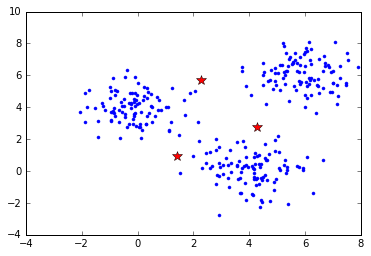

[0, 1084.0323503724783]
Iteration1
[[ 1.73282193  1.25002618]
 [ 5.45642164  2.71923605]
 [ 2.58977632  5.57084745]]
WSSSE= 860.764936391


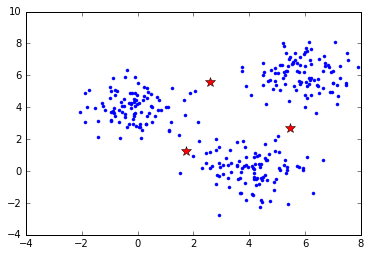

[0, 1084.0323503724783, 1, 860.76493639085311]
Iteration2
[[ 1.89120421  1.29734571]
 [ 5.8020802   3.18774763]
 [ 2.69858765  5.62580721]]
WSSSE= 828.540730722


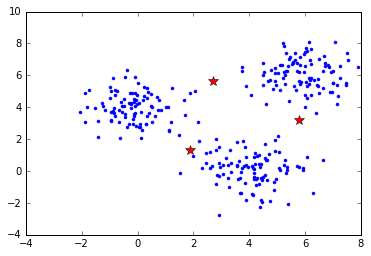

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893]
Iteration3
[[ 2.19129431  1.20119863]
 [ 6.09227926  4.12761028]
 [ 2.48419757  5.60676534]]
WSSSE= 813.625268578


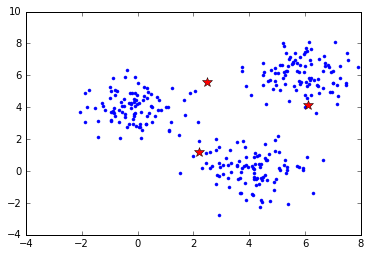

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978]
Iteration4
[[ 3.02292681  0.74855376]
 [ 6.05576492  5.83244979]
 [ 0.52638433  4.75791242]]
WSSSE= 744.963434284


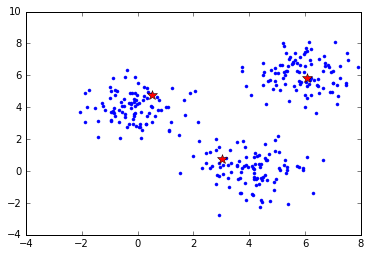

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155]
Iteration5
[[ 4.04185119  0.12488141]
 [ 5.88928783  6.0885672 ]
 [-0.15328422  3.99427176]]
WSSSE= 436.083060591


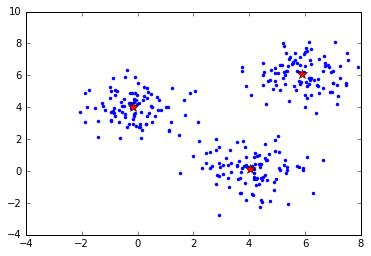

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715]
Iteration6
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.627857699


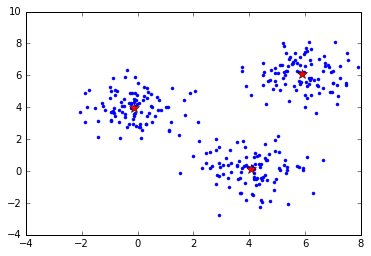

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262]
Iteration7
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


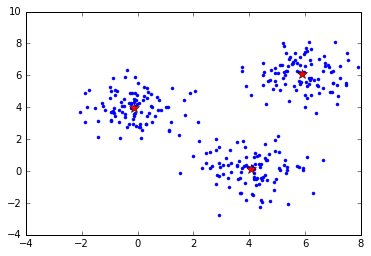

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043]
Iteration8
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


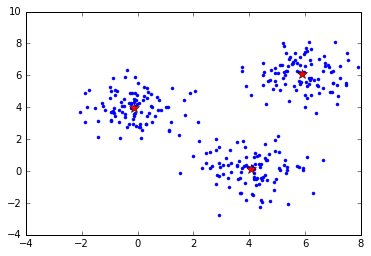

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043]
Iteration9
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


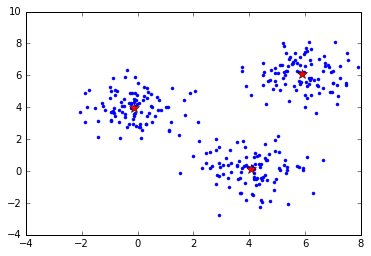

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043]
Iteration10
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


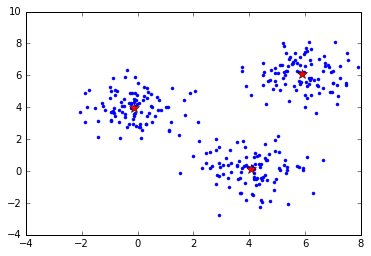

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043]
Iteration11
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


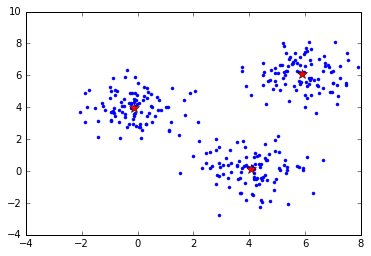

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043]
Iteration12
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


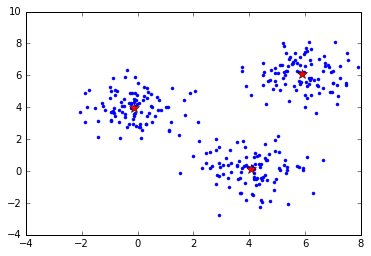

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043]
Iteration13
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


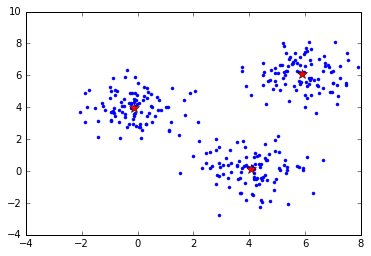

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043]
Iteration14
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


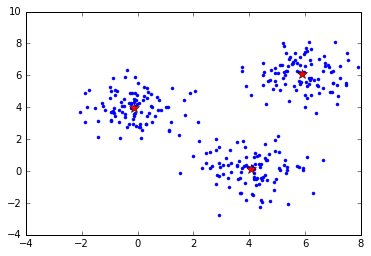

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043]
Iteration15
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


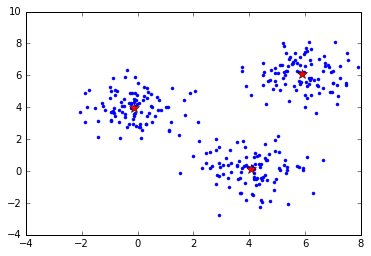

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043]
Iteration16
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


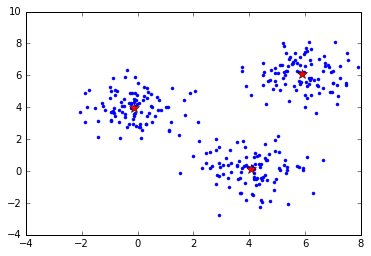

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043]
Iteration17
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


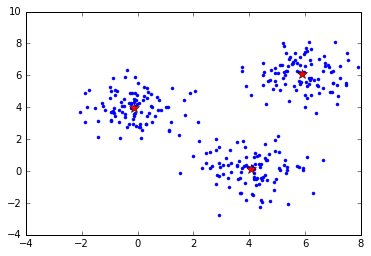

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043]
Iteration18
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


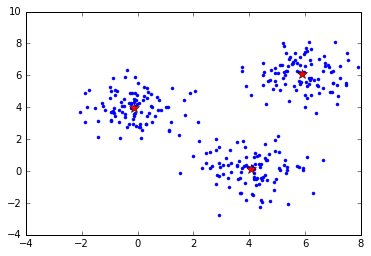

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043]
Iteration19
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


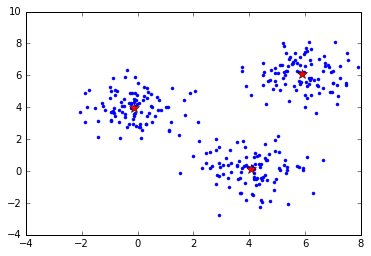

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043]
Iteration20
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


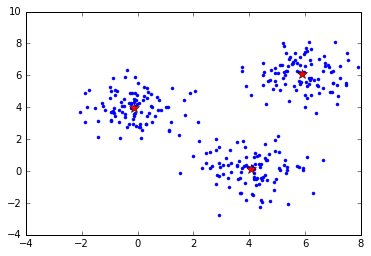

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043]
Iteration21
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


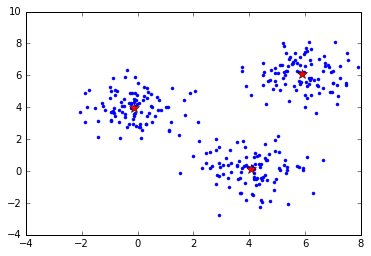

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043]
Iteration22
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


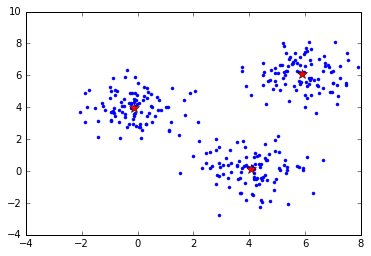

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043]
Iteration23
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


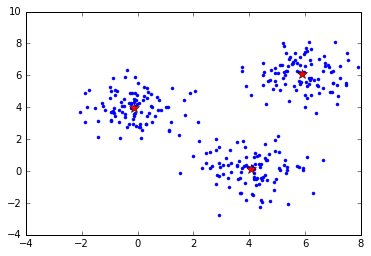

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043]
Iteration24
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


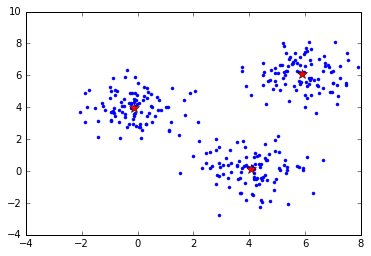

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043]
Iteration25
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


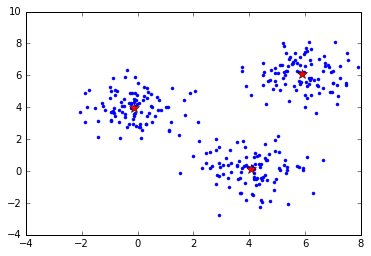

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043]
Iteration26
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


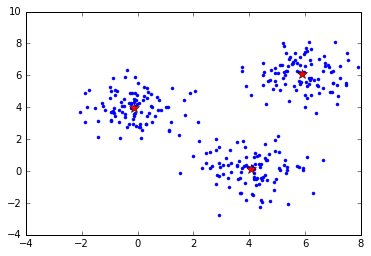

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043]
Iteration27
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


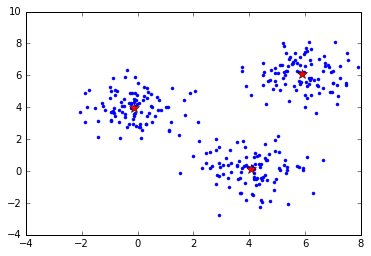

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043]
Iteration28
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


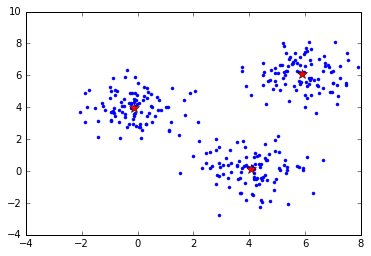

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043]
Iteration29
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


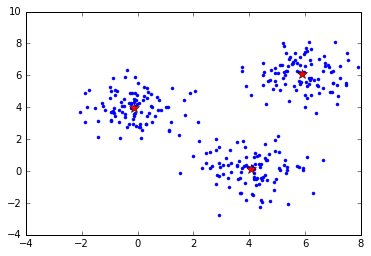

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043]
Iteration30
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


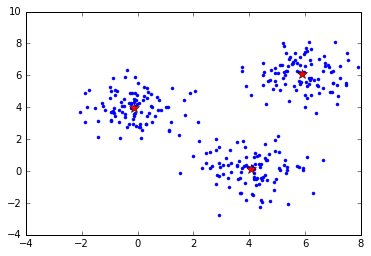

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043]
Iteration31
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


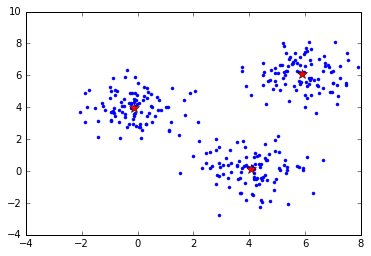

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043]
Iteration32
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


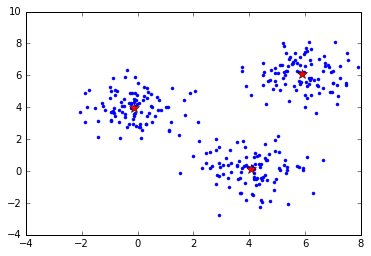

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043]
Iteration33
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


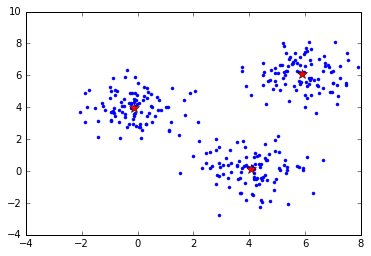

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043]
Iteration34
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


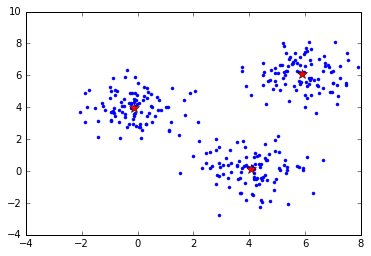

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043]
Iteration35
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


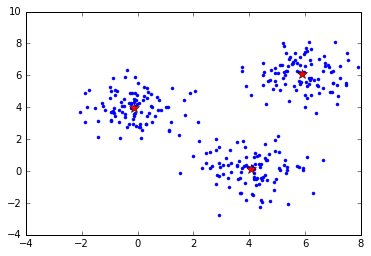

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043]
Iteration36
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


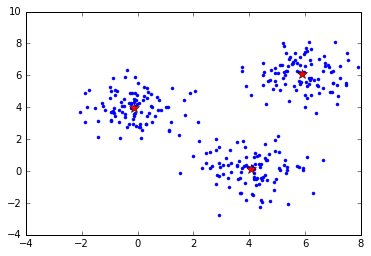

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043]
Iteration37
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSSE= 355.744702637


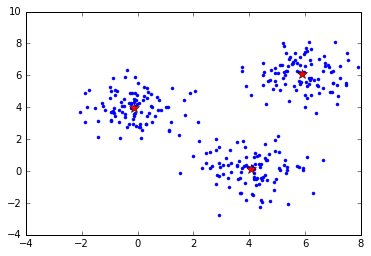

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043]
Iteration38
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]
WSSS

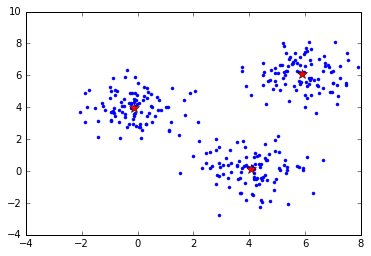

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043]
Iteration39
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.136

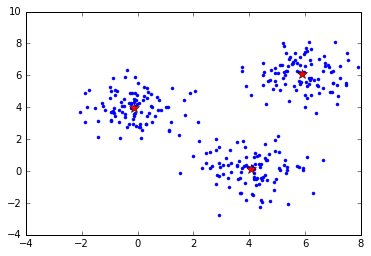

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043]
Iteration40
[[ 4.06731716  0.10368867]
 [ 5.889287

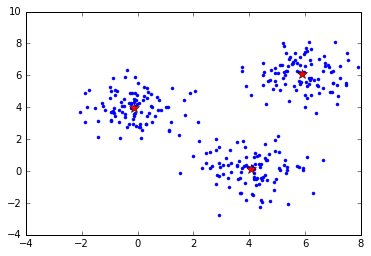

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043]
Iteration41
[[ 4.06731716 

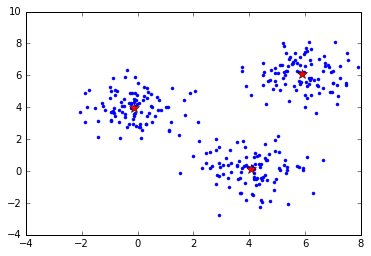

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043]
It

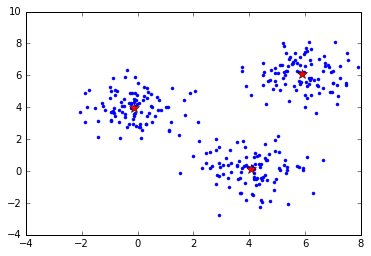

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

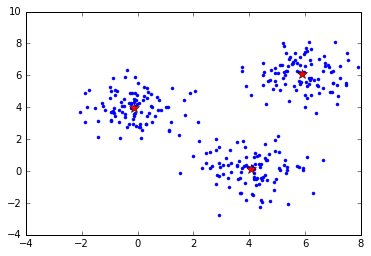

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

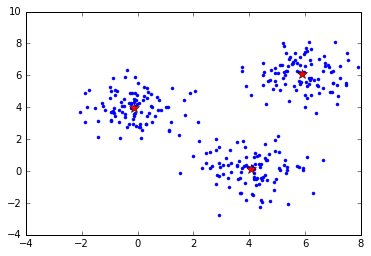

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

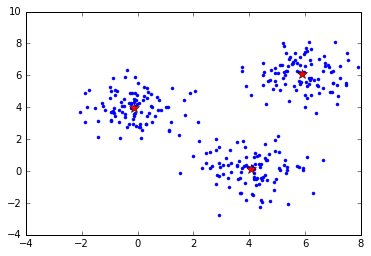

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

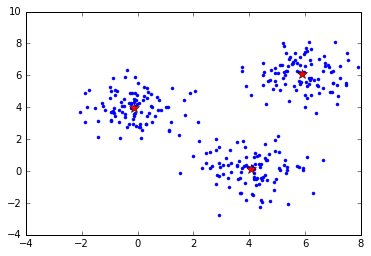

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

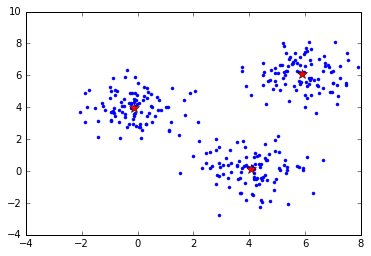

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

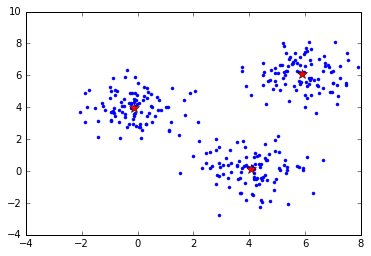

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

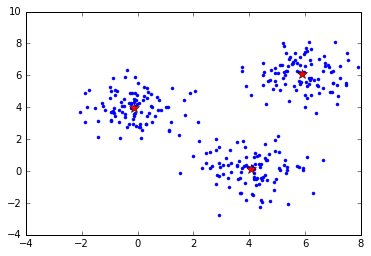

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

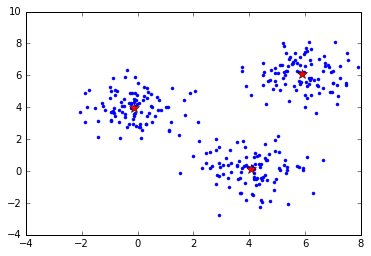

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

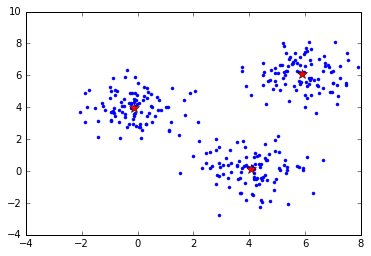

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

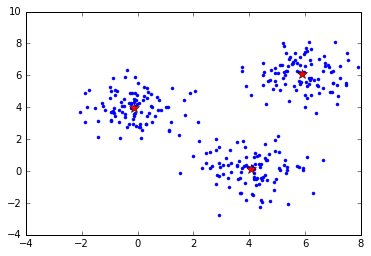

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

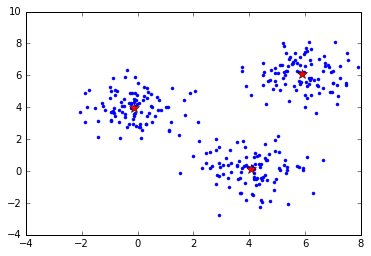

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

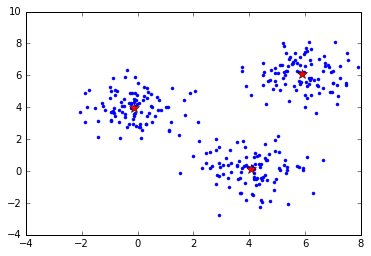

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

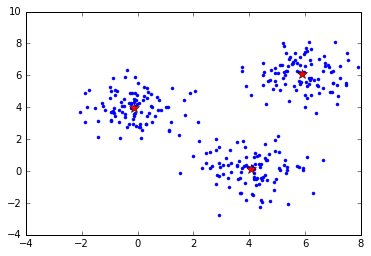

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

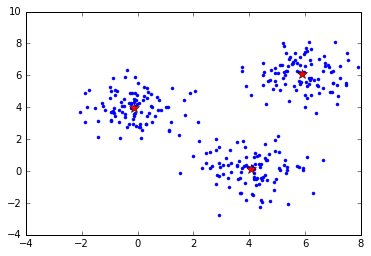

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

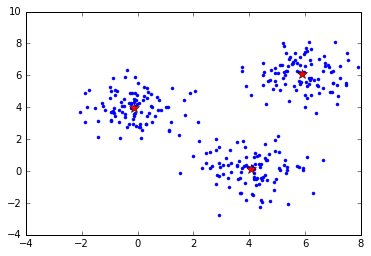

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

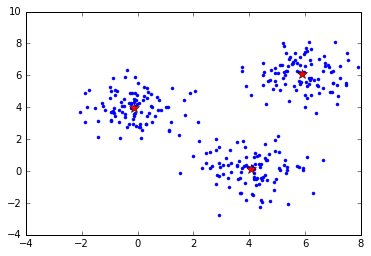

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

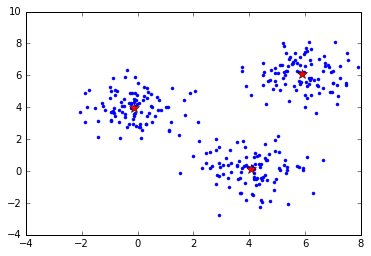

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

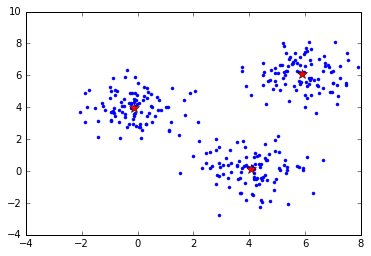

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

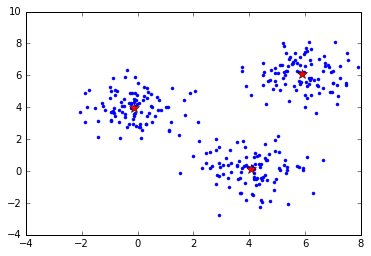

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

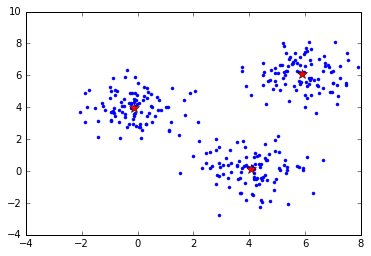

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

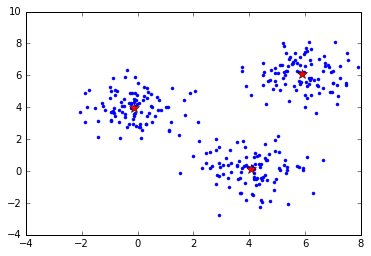

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

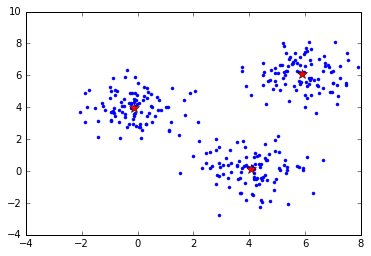

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

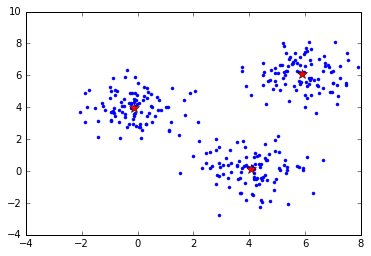

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

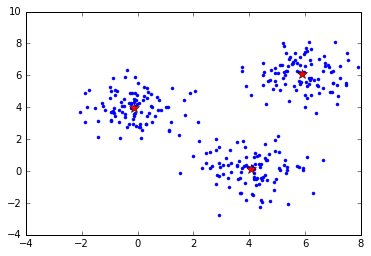

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

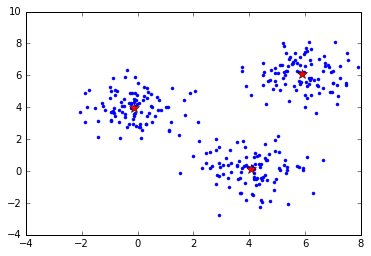

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

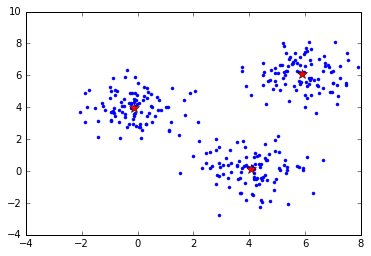

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

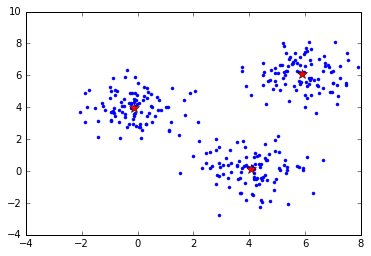

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

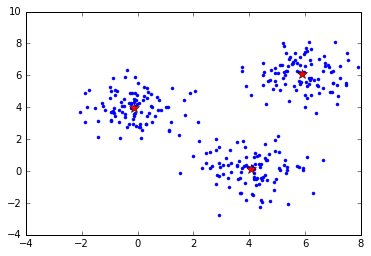

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

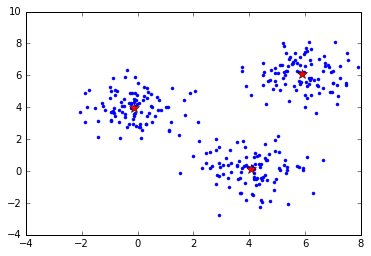

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

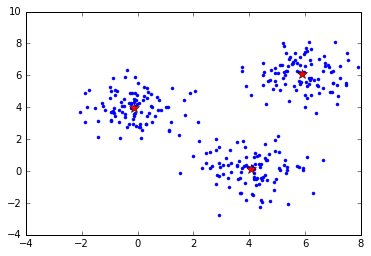

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

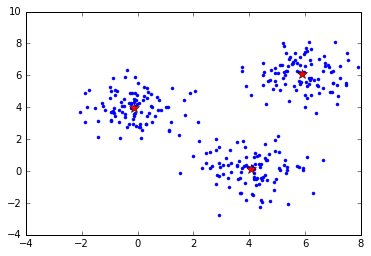

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

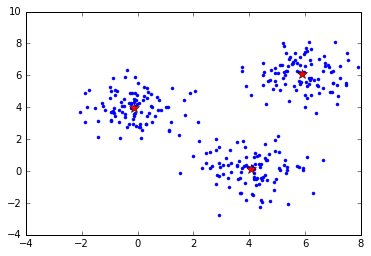

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

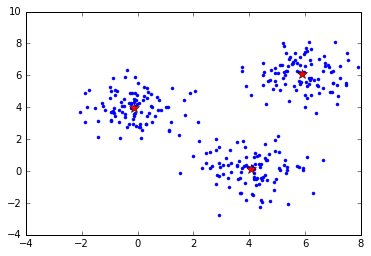

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

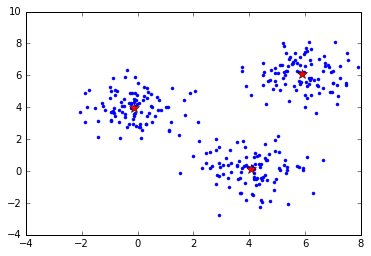

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

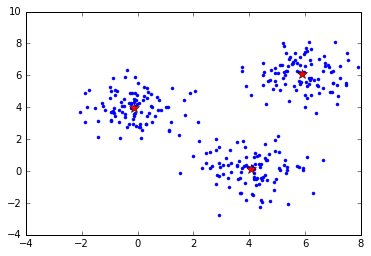

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

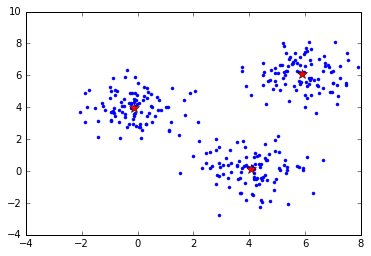

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

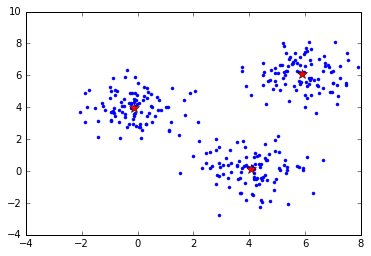

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

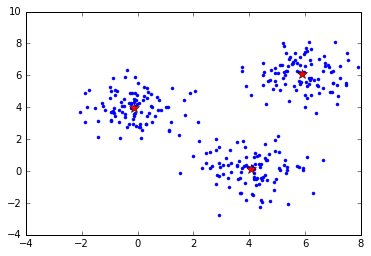

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

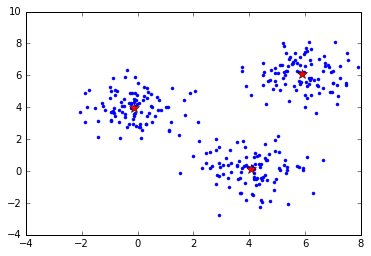

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

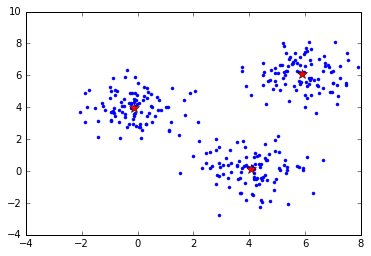

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

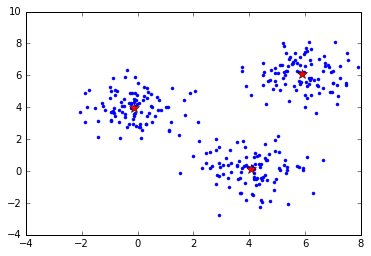

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

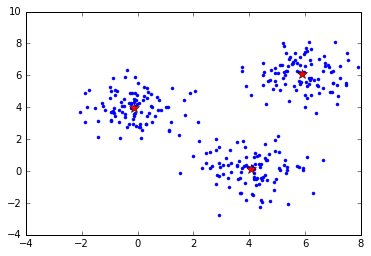

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

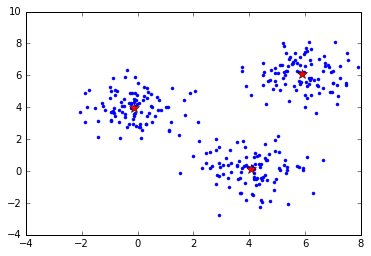

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

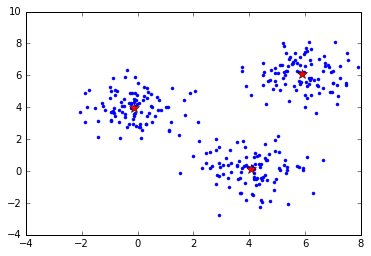

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

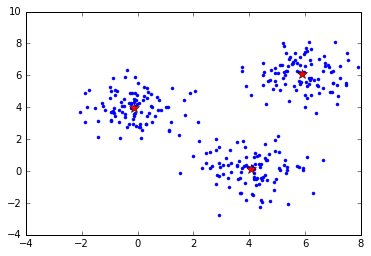

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

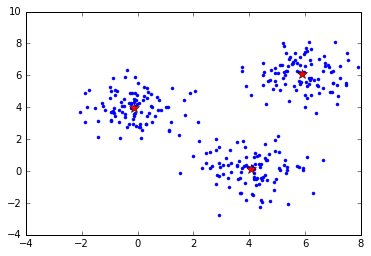

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

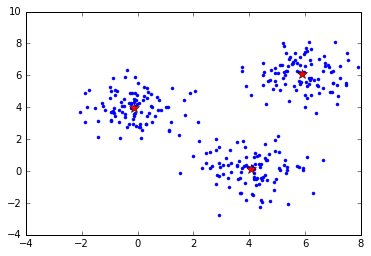

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

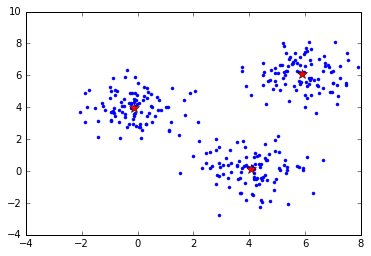

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

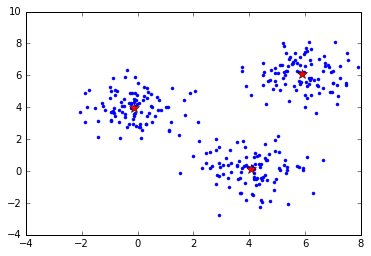

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

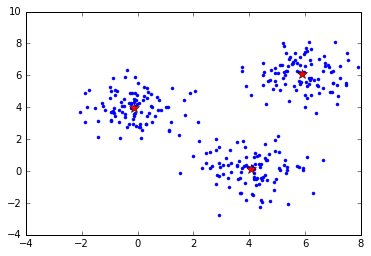

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

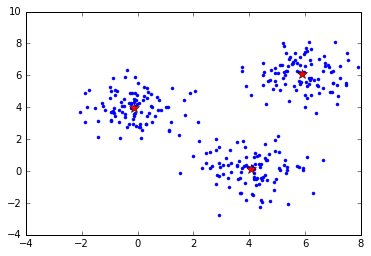

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

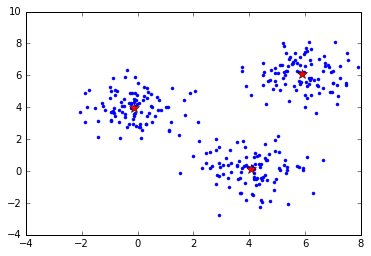

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

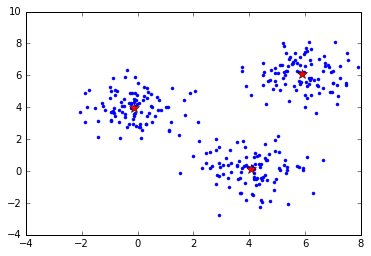

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

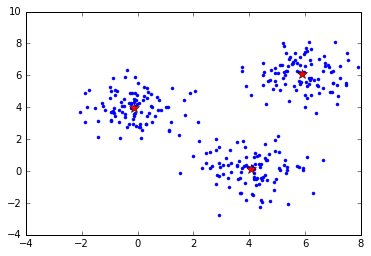

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

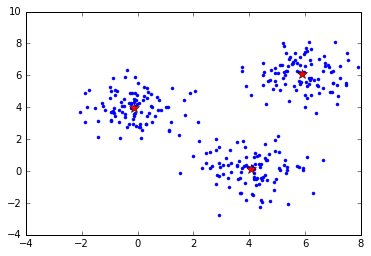

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

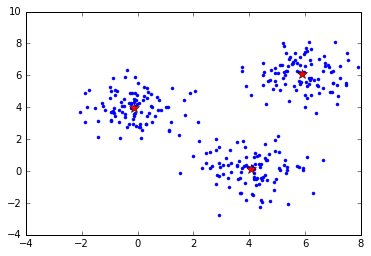

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

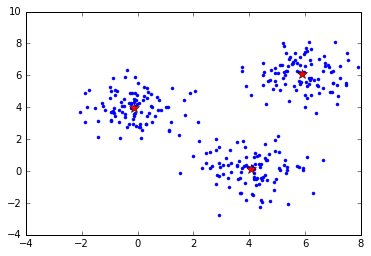

[0, 1084.0323503724783, 1, 860.76493639085311, 2, 828.54073072207893, 3, 813.6252685780978, 4, 744.96343428426155, 5, 436.08306059138715, 6, 355.62785769861262, 7, 355.74470263684043, 8, 355.74470263684043, 9, 355.74470263684043, 10, 355.74470263684043, 11, 355.74470263684043, 12, 355.74470263684043, 13, 355.74470263684043, 14, 355.74470263684043, 15, 355.74470263684043, 16, 355.74470263684043, 17, 355.74470263684043, 18, 355.74470263684043, 19, 355.74470263684043, 20, 355.74470263684043, 21, 355.74470263684043, 22, 355.74470263684043, 23, 355.74470263684043, 24, 355.74470263684043, 25, 355.74470263684043, 26, 355.74470263684043, 27, 355.74470263684043, 28, 355.74470263684043, 29, 355.74470263684043, 30, 355.74470263684043, 31, 355.74470263684043, 32, 355.74470263684043, 33, 355.74470263684043, 34, 355.74470263684043, 35, 355.74470263684043, 36, 355.74470263684043, 37, 355.74470263684043, 38, 355.74470263684043, 39, 355.74470263684043, 40, 355.74470263684043, 41, 355.74470263684043, 42

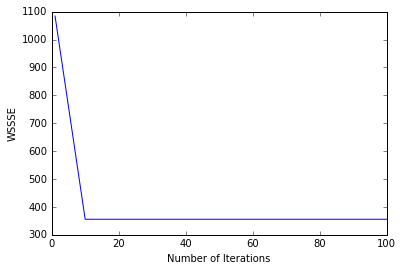

Final Results:
[[ 4.06731716  0.10368867]
 [ 5.88928783  6.0885672 ]
 [-0.13688955  3.97680788]]


In [12]:
from numpy import array
from math import sqrt
K = 3
# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[1.0,1.0],[2.0,2.0],[0.0,7.0]])

D = sc.textFile("NEW_kmeans_data.txt").cache()
parsedData2 = D.map(lambda line: array([float(x) for x in line.split(' ')]))
iter_num = 0
errorlist = []
for i in range(100): 
    cBroadcast = sc.broadcast(centroids)
    res = D.map(nearest_centroid).reduceByKey(lambda x,y:(x[0]+y[0],x[1]+y[1])).collect() # fill in the missing code
    errorval = D.map(error).reduce(lambda x, y: (x+y))
    res = sorted(res,key = lambda x : x[0])  #sort based on clusted ID
    centroids_new = np.array([x[1][0]/x[1][1] for x in res])  #divide by cluster size
    #if np.sum(np.absolute(centroids_new-centroids))<.001:
        #break
    print "Iteration" + str(iter_num)
    errorlist += iter_num, errorval
    iter_num = iter_num + 1 
    centroids = centroids_new
    print centroids
    print "WSSSE=", errorval
    plot_iteration(centroids)
    #for i in error_val:
    print errorlist 

print "final results"
print centroids
    
import matplotlib.pyplot as plt
pointstoplot = errorlist[1], errorlist[19], errorlist[39], errorlist[59], errorlist[79], errorlist[99], errorlist[199]
xaxis= 1, 10, 20, 30, 40, 50, 100
#pointstoplot= errorlist[1:9]
plt.plot(xaxis, pointstoplot)
plt.ylabel('WSSSE')
plt.xlabel('Number of Iterations')
plt.show()
    
    #print("Within Set Sum of Squared Error = " + str(WSSSE))
print "Final Results:"
print centroids






## comments: 
Broadcasting variables allows us to send out the values to the nodes, so that the data is not being trasferred back and forth between tasks. 

In [99]:
## Run Scripts, S3 Sync

<a name="HW3.5"><h2 style="color:darkgreen"> HW3.5: OPTIONAL Weighted KMeans  </h2>
[Back to Table of Contents](#TOC)

Using this provided [homegrown Kmeans code](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb), modify it to do a weighted KMeans and repeat the experiements in HW3.3. Explain  any differences between the results in HW3.3 and HW3.5.

NOTE: Weight each example as follows using the inverse vector length (Euclidean norm): 

> weight(X)= 1/||X||, 

where ||X|| = SQRT(X.X)= SQRT(X1^2 + X2^2)

Here X is vector made up of two values X1 and X2.

__[Please incorporate all referenced notebooks directly into this master notebook as cells for HW submission. I.e., HW submissions should comprise of just one notebook]__

In [100]:
import numpy as np
import csv
def data_generate(fileName, w=[0,0], size=100):
    np.random.seed(0)
    x = np.random.uniform(-4, 4, size)
    noise = np.random.normal(0, 2, size)
    y = (x * w[0] + w[1] + noise)
    data = zip(y, x)
    with open(fileName,'wb') as f:
        writer = csv.writer(f)
        for row in data:
            writer.writerow(row)
    return True

In [101]:
w = [8,-2]
data_generate('data.csv', w, 100)

In [102]:
## Run Scripts, S3 Sync

<a name="HW3.6"><h2 style="color:darkblue"> HW3.6 OPTIONAL Linear Regression</h2>
[Back to Table of Contents](#TOC)
<a name="HW3.6.1"><h2 style="color:darkblue"> HW3.6.1 OPTIONAL Linear Regression</h2>
[Back to Table of Contents](#TOC)

Using [this linear regression notebook](    http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/atzqkc0p1eajuz6/LinearRegression-Notebook-Challenge.ipynb):


* Generate 2 sets of data with 100 data points using the data generation code provided and plot each in separate plots. Call one the training set and the other the testing set.

* Using MLLib's LinearRegressionWithSGD train up a linear regression model with the training dataset and evaluate with the testing set. What a good number of iterations for training the linear regression model? Justify with plots (e.g., plot MSE as a function of the number of iterations) and words. 


In [ ]:
np.random.seed(0)
x = np.random.uniform(-4, 4, 100)
noise = np.random.normal(0, 2, 100)
y = (x * w[0] + w[1] + noise)
data = zip(y, x)
print data

In [91]:
import numpy as np
import csv
def data_generate(fileName, w=[0,0], size=100):
    np.random.seed(0)
    x = np.random.uniform(-4, 4, size)
    noise = np.random.normal(0, 2, size)
    y = (x * w[0] + w[1] + noise)
    data = zip(y, x)
    with open(fileName,'wb') as f:
        writer = csv.writer(f)
        for row in data:
            writer.writerow(row)
    return True

In [90]:
w = [8,-2]
data_generate('training.csv', w, 100)

True

In [92]:
w = [8,-2]
data_generate('testing.csv', w, 100)

True

In [105]:
%matplotlib inline
import matplotlib.pyplot as plt
def dataPlot(file, w):
    with open(file, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            plt.plot(float(row[1]), float(row[0]),'o'+'r')
    plt.xlabel("x")
    plt.ylabel("y")
    x = [-4, 4]
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x,y, linewidth=2.0)
    plt.grid()
    plt.show()

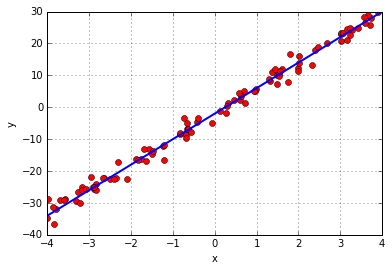

In [106]:
dataPlot('training.csv',w)

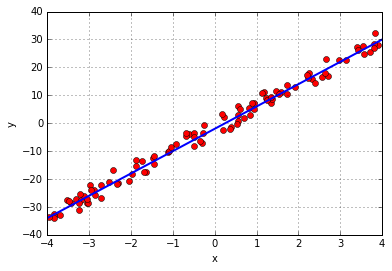

In [107]:
dataPlot('testing.csv',w)

In [108]:
import numpy as np

def linearRegressionGD(data, wInitial=None, learningRate=0.05, iterations=50):
    featureLen = len(data.take(1)[0])-1
    n = data.count()
    if wInitial is None:  #start learning from a random vector
        w = np.random.normal(size=featureLen) # w should be broadcasted if it is large
    else:                 #start from provided vector
        w = wInitial
    for i in range(iterations):
        wBroadcast = sc.broadcast(w)   #make available in memory as read-only to the executors (for mappers and reducers)
        gradient = data.map(lambda d: -2 * (d[0] - np.dot(wBroadcast.value, d[1:])) * np.array(d[1:])) \
                    .reduce(lambda a, b: a + b)
        w = w - learningRate * gradient/n
    return w

In [109]:
from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD, LinearRegressionModel

# Load and parse the data
def parsePoint(line):
    values = [float(x) for x in line.split(',')]
    return LabeledPoint(values[0], values[1:])

data = sc.textFile("training.csv")
parsedDatatrain = data.map(parsePoint)
data2= sc.textFile("testing.csv")
parsedDatatest= data2.map(parsePoint)

# Build the model
model = LinearRegressionWithSGD.train(parsedData, intercept=True, iterations=50)
print model

valuesAndPredstest = parsedDatatest.map(lambda p: (p.label, model.predict(p.features)))
valuesAndPredstrain = parsedDatatrain.map(lambda p: (p.label, model.predict(p.features)))

trainMSE = valuesAndPredstrain.map(lambda (v, p): (v - p)**2)\
                    .reduce(lambda x, y: x + y) / valuesAndPredstrain.count()
print("Mean Squared Error train = " + str(trainMSE))
testMSE = valuesAndPredstest.map(lambda (v, p): (v - p)**2)\
                    .reduce(lambda x, y: x + y) / valuesAndPredstest.count()
print("Mean Squared Error test = " + str(testMSE))

# Save and load model
#model.save(sc, "target/tmp/pythonLinearRegressionWithSGDModel")
#sameModel = LinearRegressionModel.load(sc, "target/tmp/pythonLinearRegressionWithSGDModel")


(weights=[7.92170367752], intercept=-1.8411713992797631)
Mean Squared Error train = 3.19904870446
Mean Squared Error test = 4.03415105467


In [110]:
data = sc.textFile('training.csv').map(lambda line: [float(v) for v in line.split(',')]+[1.0]).cache()
linearRegressionGD(data)

array([ 7.92153896, -1.82873437])

In [111]:
def ierationsPlot(fileName, truew):
    x = [-4, 4]
    w = truew
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x, y, 'b', label="True line", linewidth=4.0)
    
    data = sc.textFile(fileName).map(lambda line: [float(v) for v in line.split(',')]+[1.0]).cache()
    n = data.count()
    
    np.random.seed(400)
    w = np.random.normal(0,1,2)
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x, y, 'r--', label="After 0 Iterations", linewidth=2.0)
    squared_error = data.map(lambda d: (d[0] - np.dot(w, d[1:]))**2).reduce(lambda a, b: a + b)
    print "Mean Squared Error after 0 iterations: " + str(squared_error/n)
    

    
    w = linearRegressionGD(data, w, iterations=2)
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x, y, 'g--', label="After 2 Iterations", linewidth=2.0)
    squared_error = data.map(lambda d: (d[0] - np.dot(w, d[1:]))**2).reduce(lambda a, b: a + b)
    print "Mean Squared Error after 2 iterations: " + str(squared_error/n)
    
    w = linearRegressionGD(data, w, iterations=4)
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x, y, 'm--', label="After 4 Iterations", linewidth=2.0)
    squared_error = data.map(lambda d: (d[0] - np.dot(w, d[1:]))**2).reduce(lambda a, b: a + b)
    print "Mean Squared Error after 4 iterations: " + str(squared_error/n)
    
    w = linearRegressionGD(data, w, iterations=6)
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x, y, 'y--', label="After 6 Iterations", linewidth=2.0)
    squared_error = data.map(lambda d: (d[0] - np.dot(w, d[1:]))**2).reduce(lambda a, b: a + b)
    print "Mean Squared Error after 6 iterations: " + str(squared_error/n)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, fontsize=20, borderaxespad=0.)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid()
    plt.show()

Mean Squared Error after 0 iterations: 470.368860721
Mean Squared Error after 2 iterations: 24.6086248099
Mean Squared Error after 4 iterations: 4.73772423484
Mean Squared Error after 6 iterations: 3.62760957585


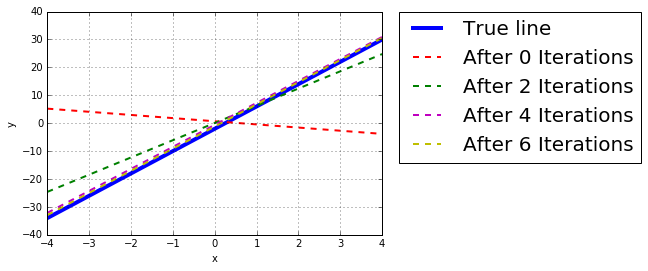

In [102]:
ierationsPlot('training.csv',w)

Mean Squared Error after 0 iterations: 464.394955261
Mean Squared Error after 2 iterations: 27.0859380611
Mean Squared Error after 4 iterations: 4.9932567759
Mean Squared Error after 6 iterations: 4.25056900765


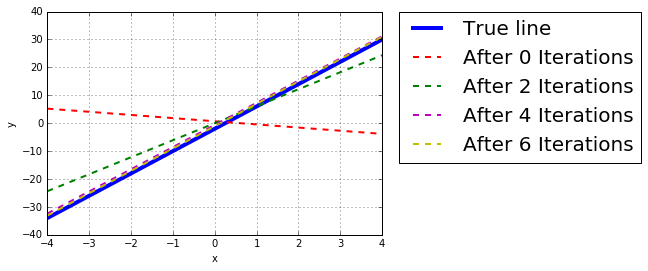

In [112]:
ierationsPlot('testing.csv',w)

4 iterations appears to be the best number, without overfitting the dataset. I changed the number generator so that the sets were different, so I could legitamately evaluate the differences.

<a name="HW3.6.2"><h2 style="color:darkblue"> HW3.6.2 OPTIONAL Linear Regression</h2>
[Back to Table of Contents](#TOC)

In the notebook provided above, in the cell labeled "Gradient descent (regularization)".

* Fill in the blanks and get this code to work for LASS0 and RIDGE linear regression.

* Using the data from 3.6.1 tune the hyper parameters of your LASS0 and RIDGE regression. Report your findings with words and plots.

In [103]:
## Code goes here

In [104]:
## Drivers & Runners

In [105]:
## Run Scripts, S3 Sync

<a name="HW3.7"><h2 style="color:darkgreen"> HW3.7 OPTIONAL Error surfaces </h2>
[Back to Table of Contents](#TOC)

Here is a link to R code with 1 test drivers that plots the linear regression model in  model space and in the domain space:

> https://www.dropbox.com/s/3xc3kwda6d254l5/PlotModelAndDomainSpaces.R?dl=0

Here is a sample output from this script: 
      
> https://www.dropbox.com/s/my3tnhxx7fr5qs0/image%20%281%29.png?dl=0

Please use this as inspiration and code a equivalent error surface and heatmap (with isolines) in Spark and show the trajectory of learning taken during gradient descent(after each n-iterations of Gradient Descent):


Using Spark and  Python (using the above R Script as inspiration), plot the error surface for the linear regression model using a heatmap and contour plot. 
Also plot the current model in the original domain space for every 10th iteration.  Plot them side by side if possible  for each iteration: lefthand side plot is the model space(w0 and w01) and the righthand side plot is domain space (plot the corresponding model and training data in the problem domain space) with a final pair of graphs showing the entire trajectory in the model and domain space. Make sure to label your plots with iteration numbers, function, model space versus original domain space, MSE on the training data etc.

Also plot the MSE as a function of each iteration (possibly every 10th iteration). Dont forget to label both axis and the graph also. __[Please incorporate all referenced notebooks directly into this master notebook as cells for HW submission. I.e., HW submissions should comprise of just one notebook]__





In [106]:
## Code goes here

In [107]:
## Drivers & Runners

In [108]:
## Run Scripts, S3 Sync

[Back to Table of Contents](#TOC)
<center><div class='jumbotron'><h2 style='color:green'>-------  END OF HWK 9 --------</h2></div></center>